# Travel Package Purchase Prediction Project

## Background and Context 

__"Visit with us"__ is a tourism company. The company is planning to launch a new __Wellness Tourism Package__. Company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient.

## Objective
As Data Scientist at "Visit with us" travel company, we have to analyze the customers' data and information to provide recommendations to the Policy Maker and Marketing Team.<br/>
We will also build a model to predict the potential customer who is going to purchase the newly introduced travel package.

## Data Dictionary
### Customer details:

* __CustomerID__: Unique customer ID
* __ProdTaken__: Whether the customer has purchased a package or not (0: No, 1: Yes)
* __Age__: Age of customer
* __TypeofContact__: How customer was contacted (Company Invited or Self Inquiry)
* __CityTier__: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. Tier 1 > Tier 2 > Tier 3
* __Occupation__: Occupation of customer
* __Gender__: Gender of customer
* __NumberOfPersonVisiting__: Total number of persons planning to take the trip with the customer
* __PreferredPropertyStar__: Preferred hotel property rating by customer
* __MaritalStatus__: Marital status of customer
* __NumberOfTrips__: Average number of trips in a year by customer
* __Passport__: The customer has a passport or not (0: No, 1: Yes)
* __OwnCar__: Whether the customers own a car or not (0: No, 1: Yes)
* __NumberOfChildrenVisiting__: Total number of children with age less than 5 planning to take the trip with the customer
* __Designation__: Designation of the customer in the current organization
* __MonthlyIncome__: Gross monthly income of the customer

### Customer interaction data:  
* __PitchSatisfactionScore__: Sales pitch satisfaction score
* __ProductPitched__: Product pitched by the salesperson
* __NumberOfFollowups__: Total number of follow-ups has been done by the salesperson after the sales pitch
* __DurationOfPitch__: Duration of the pitch by a salesperson to the customer

In [1]:
# Course: Ensemble Techniques
# Project: Travel Package Purchase Prediction Project
# Student: Sameer Girolkar
# Date: Dec 7, 2021

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

## Initial setup
Let's start by importing the required libraries, setting up some basic configurations for EDA.<br/>
We will also write some basic functions to help us visualize the data.

In [3]:
# Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
)
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

<IPython.core.display.Javascript object>

### Functions for EDA and Visualizations

In [4]:
# function to plot histogram and barplot together
def histogram_boxplot(
    data, feature, figsize=(12, 7), kde=False, bins=None, hue=None, element="bars"
):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet", hue=hue
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data,
        x=feature,
        kde=kde,
        ax=ax_hist2,
        bins=bins,
        palette="winter",
        hue=hue,
        element=element,
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, hue=hue, element=element
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

<IPython.core.display.Javascript object>

In [5]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 5, 5))
    else:
        plt.figure(figsize=(n + 5, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

In [6]:
# function to create box-plots by category
def box_plot_by_cat(data, category_col, y, n=None):
    """
    Boxplot by category

    data: dataframe
    category_col: column for which the boxplot will be created
    y: independent variable
    n: no of values to plot
    """
    count = data[category_col].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    sns.boxplot(
        x=category_col,
        y=y,
        data=data,
        order=data[category_col].value_counts().index[:n].sort_values(),
    )
    plt.xticks(rotation=90)
    plt.show()

<IPython.core.display.Javascript object>

In [7]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 75)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 7, 6))

    for c in ax.containers:
        ax.bar_label(c, label_type="center", size=14, fmt="%.2f")

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    plt.show()

<IPython.core.display.Javascript object>

In [8]:
# Removes the limit from the number of displayed columns
pd.set_option("display.max_columns", None)

# Let's set the limit of 200 rows max
pd.set_option("display.max_rows", 200)

<IPython.core.display.Javascript object>

In [9]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "30",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

<IPython.core.display.Javascript object>

## Overview of the Dataset
Let's now read and observe the data

In [10]:
# Note: I have manually saved the xlsx file as a CSV file using Excel
# Read the data from the file
data = pd.read_csv("Tourism.csv")

<IPython.core.display.Javascript object>

In [11]:
# lets see how many rows and columns are present in the data
data.shape

(4888, 20)

<IPython.core.display.Javascript object>

There are 4888 rows and 20 columns in the original dataset

In [ ]:
# Check data types and number of non-null values for each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

<IPython.core.display.Javascript object>

#### Original Dataset observations
* 14 Numeric columns (7 float and 7 int)
* And 6 object columns
* Some categorical columns are treated as numeric
* The number of non-null values of some columns are less than the number of total rows in the dataset i.e. there are some null value. We can further confirm this using isna() method.

In [13]:
# lets see which columns have nulls
null_cols = data.isna().sum()
null_cols = null_cols[null_cols.values > 0]
null_cols

Age                         226
TypeofContact                25
DurationOfPitch             251
NumberOfFollowups            45
PreferredPropertyStar        26
NumberOfTrips               140
NumberOfChildrenVisiting     66
MonthlyIncome               233
dtype: int64

<IPython.core.display.Javascript object>

__There are missing or null values for 8 columns__<br/>
We will impute or drop the null values for each of these columns individually after the univariate analysis

### Summary of the dataset

In [14]:
# Lets take a look at the basic stats for the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4888.0,202443.500000,1411.188388,200000.0,201221.75,202443.5,203665.25,204887.0
ProdTaken,4888.0,0.188216,0.390925,0.0,0.00,0.0,0.00,1.0
Age,4662.0,37.622265,9.316387,18.0,31.00,36.0,44.00,61.0
CityTier,4888.0,1.654255,0.916583,1.0,1.00,1.0,3.00,3.0
DurationOfPitch,4637.0,15.490835,8.519643,5.0,9.00,13.0,20.00,127.0
NumberOfPersonVisiting,4888.0,2.905074,0.724891,1.0,2.00,3.0,3.00,5.0
NumberOfFollowups,4843.0,3.708445,1.002509,1.0,3.00,4.0,4.00,6.0
PreferredPropertyStar,4862.0,3.581037,0.798009,3.0,3.00,3.0,4.00,5.0
NumberOfTrips,4748.0,3.236521,1.849019,1.0,2.00,3.0,4.00,22.0
Passport,4888.0,0.290917,0.454232,0.0,0.00,0.0,1.00,1.0


<IPython.core.display.Javascript object>

In [15]:
data.describe(include="object").T

,count,unique,top,freq
TypeofContact,4863,2,Self Enquiry,3444
Occupation,4888,4,Salaried,2368
Gender,4888,3,Male,2916
ProductPitched,4888,5,Basic,1842
MaritalStatus,4888,4,Married,2340
Designation,4888,5,Executive,1842


<IPython.core.display.Javascript object>

#### Observations
1. DurationOfPitch seems to have some outliers because the 75 percentile and max values are far apart
2. NumberOfTrips as well has some outliers
3. Majority of the customers are Male
4. Majority of the customers are Salaried
5. Majority of the customers are Married

### Conversion to Category 
From the data dictionary, we expect a bunch of columns to be categorical, but most of them are represented as numerical columns.<br/>
Let's take a look at the counts of unique values in each columns and decide which of them should be converted to category.<br/>
We will be converting some the columns (with less than 15 unique values) to Categorical columns<br/>
After the univariate and bivariate analysis we will replace the categorical columns with dummies

In [16]:
data.nunique(dropna=True)

CustomerID                  4888
ProdTaken                      2
Age                           44
TypeofContact                  2
CityTier                       3
DurationOfPitch               34
Occupation                     4
Gender                         3
NumberOfPersonVisiting         5
NumberOfFollowups              6
ProductPitched                 5
PreferredPropertyStar          3
MaritalStatus                  4
NumberOfTrips                 12
Passport                       2
PitchSatisfactionScore         5
OwnCar                         2
NumberOfChildrenVisiting       4
Designation                    5
MonthlyIncome               2475
dtype: int64

<IPython.core.display.Javascript object>

Based on description in the data dictionary and the counts of unique values, following columns should be converted to categories
* TypeofContact
* Occupation
* Gender
* NumberOfPersonVisiting
* NumberOfFollowups
* ProductPitched
* PreferredPropertyStar
* MaritalStatus
* NumberOfTrips
* PitchSatisfactionScore
* NumberOfChildrenVisiting
* Designation

ProdTaken, Passport & OwnCar were not converted to categories as they only have 1 and 0 values<br/>
CityTier was not converted to category because the values are ordered

In [17]:
# Iterate over all column identified as categories and convert to category
cat_cols = [
    "TypeofContact",
    "Occupation",
    "Gender",
    "NumberOfPersonVisiting",
    "NumberOfFollowups",
    "ProductPitched",
    "PreferredPropertyStar",
    "MaritalStatus",
    "NumberOfTrips",
    "PitchSatisfactionScore",
    "NumberOfChildrenVisiting",
    "Designation",
]
for col in cat_cols:
    data[col] = data[col].astype("category")

<IPython.core.display.Javascript object>

Check data types after conversion

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CustomerID                4888 non-null   int64   
 1   ProdTaken                 4888 non-null   int64   
 2   Age                       4662 non-null   float64 
 3   TypeofContact             4863 non-null   category
 4   CityTier                  4888 non-null   int64   
 5   DurationOfPitch           4637 non-null   float64 
 6   Occupation                4888 non-null   category
 7   Gender                    4888 non-null   category
 8   NumberOfPersonVisiting    4888 non-null   category
 9   NumberOfFollowups         4843 non-null   category
 10  ProductPitched            4888 non-null   category
 11  PreferredPropertyStar     4862 non-null   category
 12  MaritalStatus             4888 non-null   category
 13  NumberOfTrips             4748 non-null   catego

<IPython.core.display.Javascript object>

## EDA

## Univariate analysis

### CustomerID

This is just an ID column. lets just drop it

In [19]:
data.drop("CustomerID", axis=1, inplace=True)

<IPython.core.display.Javascript object>

### ProdTaken
This is the target column. Lets take a look at the distribution of values

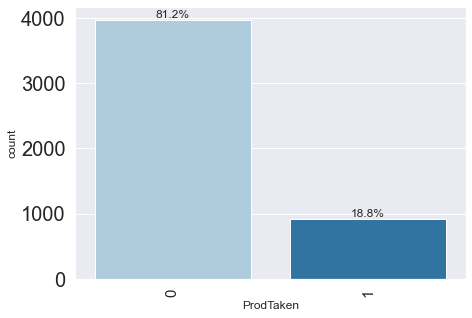

<IPython.core.display.Javascript object>

In [20]:
labeled_barplot(data, "ProdTaken", perc=True)

18.8% of the customers have purchased the product<br>
81.2% of the customers did not purchase the product

### Age
let's take a look at the distribution of Age data

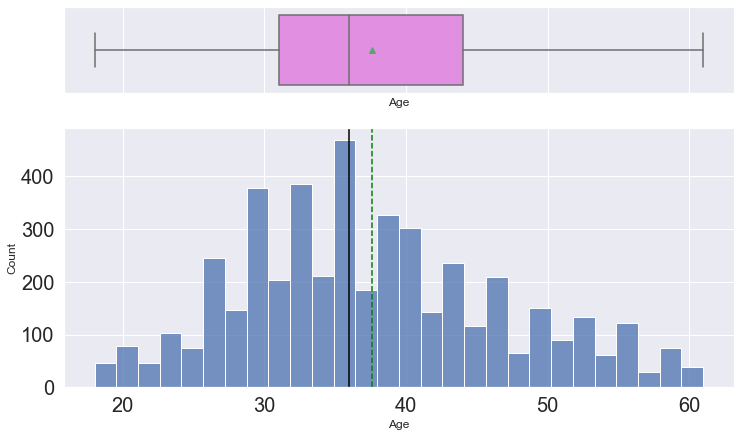

<IPython.core.display.Javascript object>

In [21]:
histogram_boxplot(data, "Age")

Age looks evenly distributed and there are not any outliers in the Age Data<br><br>
Based on this observation it sounds safe to impute nulls in the Age columns with the mean value

In [22]:
data["Age"].fillna(data["Age"].dropna().mean(), inplace=True)

<IPython.core.display.Javascript object>

Lets look at the distribution after the null imputation

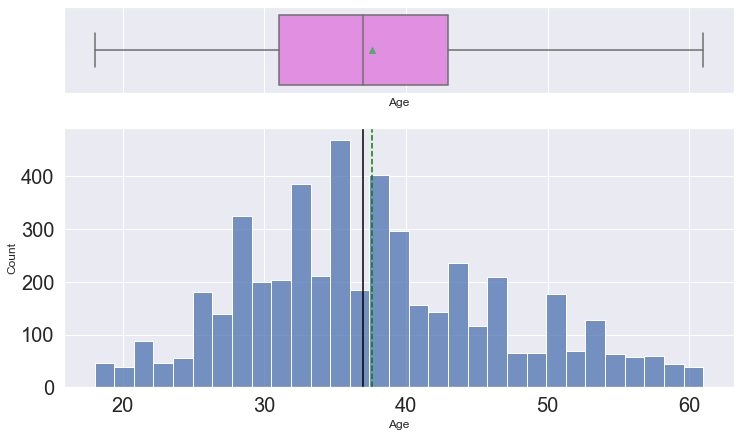

<IPython.core.display.Javascript object>

In [23]:
histogram_boxplot(data, "Age")

Null imputation with mean value did not significantly affect the distribution of the Age data 

### TypeofContact
Let's take a look at the TypeofContact distribution<br><br>
25 values are null or missing in this column. Based on the description in the data dictionary, it is safe to assume that if the company contacted a customer, this value will be tracked carefully and will not be missing. with this assumption, __we will be treating the missing values as Self Enquiry__

In [24]:
data["TypeofContact"].fillna("Self Enquiry", inplace=True)

<IPython.core.display.Javascript object>

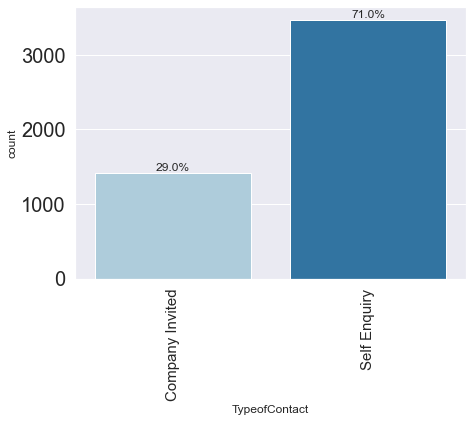

<IPython.core.display.Javascript object>

In [25]:
labeled_barplot(data, "TypeofContact", True)

29% of the customers were contacted by the company<br>
71% customers reached out to the company

### CityTier

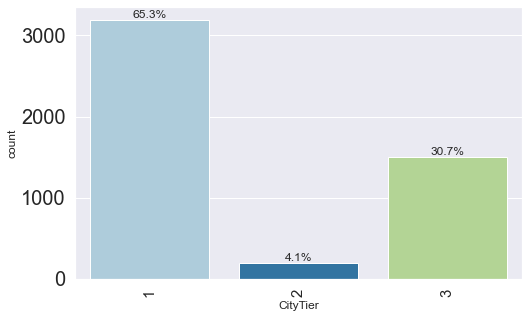

<IPython.core.display.Javascript object>

In [26]:
labeled_barplot(data, "CityTier", True)

Most of the customers are from Tier 1 cities.
* 65.3% customers are from Tier 1 cities 
* 4.1% customers are from Tier 2 cities
* 30.7% customers are from Tier 3 cities

### DurationOfPitch
Let's look at the distribution of DurationOfPitch data

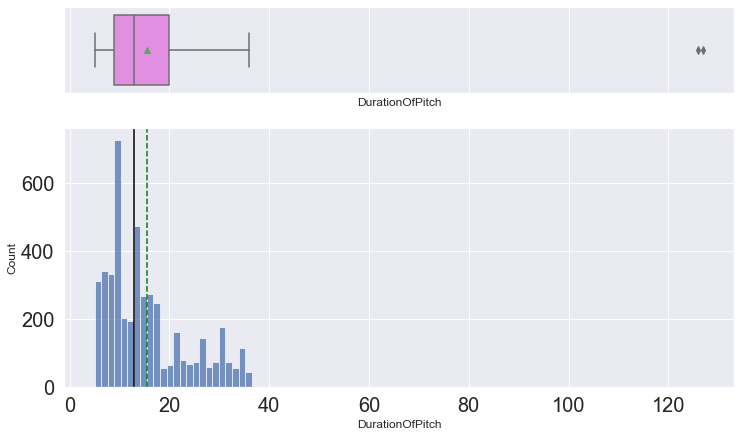

<IPython.core.display.Javascript object>

In [27]:
histogram_boxplot(data, "DurationOfPitch")

__Clearly there are 2 outliers in DurationOfPitch__, Lets take a look at those.

In [28]:
data[data["DurationOfPitch"] > 40]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
1434,0,37.622265,Company Invited,3,126.0,Salaried,Male,2,3.0,Basic,3.0,Married,3.0,0,1,1,1.0,Executive,18482.0
3878,0,53.000000,Company Invited,3,127.0,Salaried,Male,3,4.0,Basic,3.0,Married,4.0,0,1,1,2.0,Executive,22160.0


<IPython.core.display.Javascript object>

Even after ignoring the outliers, DurationOfPitch looks slightly right skewed.<br>
There are 251 null or missing values in DurationOfPitch. Considering the right skewness it will be better to impute these values with the median values of the column

In [29]:
data["DurationOfPitch"].fillna(data["DurationOfPitch"].dropna().median(), inplace=True)

<IPython.core.display.Javascript object>

Lets look at the distribution after the null imputation

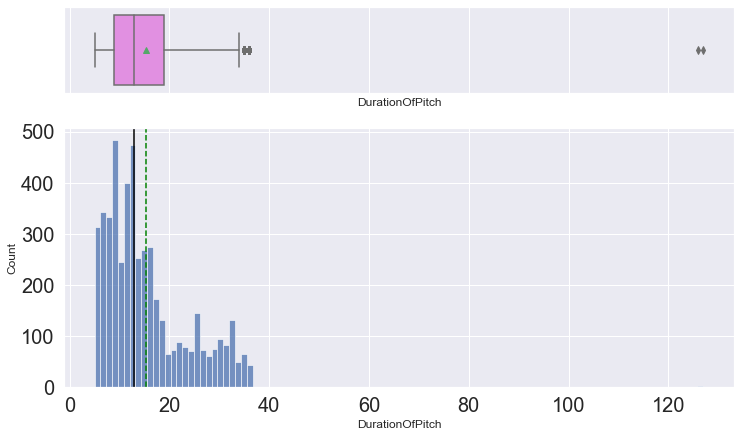

<IPython.core.display.Javascript object>

In [30]:
histogram_boxplot(data, "DurationOfPitch")

Null imputation made the distribution slightly better. It still is right skewed.

### Occupation
Lets look at the Occupation data

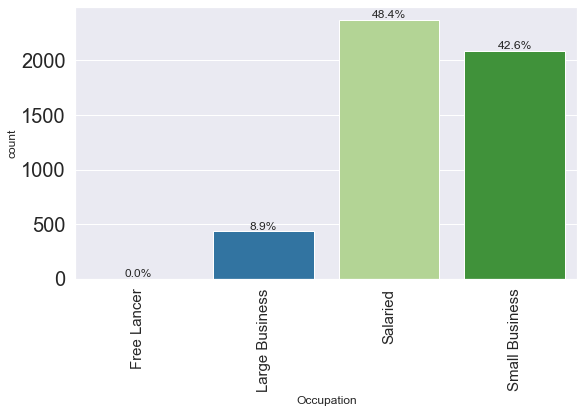

<IPython.core.display.Javascript object>

In [31]:
labeled_barplot(data, "Occupation", perc=True)

In [32]:
data["Occupation"].value_counts()

Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64

<IPython.core.display.Javascript object>

* Most of the customers are either Salaried or Small Business Owners
* There are 2 Free Lancer customers, bar-plot shows it as 0% because of rounding off

### Gender
Lets look at the Gender distribution

In [33]:
data["Gender"].value_counts()

Male       2916
Female     1817
Fe Male     155
Name: Gender, dtype: int64

<IPython.core.display.Javascript object>

There seems to be a spelling mistake in some cases where "Female" is typed as "Fe Male". Lets fix this.

In [34]:
data["Gender"].replace("Fe Male", "Female", inplace=True)

<IPython.core.display.Javascript object>

In [35]:
# Check counts after data correction
data["Gender"].value_counts()

Male      2916
Female    1972
Name: Gender, dtype: int64

<IPython.core.display.Javascript object>

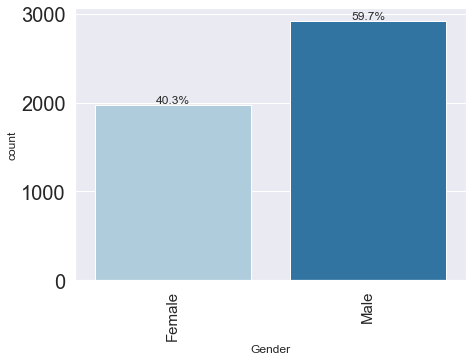

<IPython.core.display.Javascript object>

In [36]:
labeled_barplot(data, "Gender", perc=True)

2916 (59.7%) customers are Males<br>
1972 (40.3%) customers are Females

### NumberOfPersonVisiting
Lets take a look at the NumberOfPersonVisiting distribution

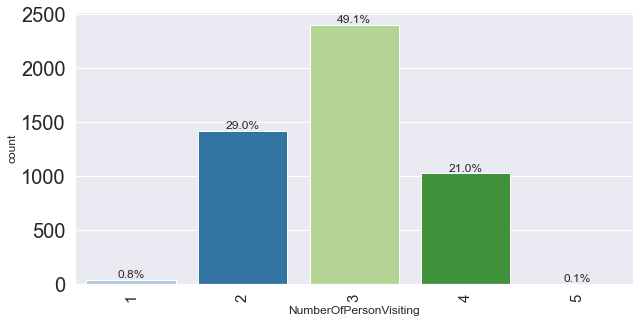

<IPython.core.display.Javascript object>

In [37]:
labeled_barplot(data, "NumberOfPersonVisiting", perc=True)

Most cases NumberOfPersonVisiting is 2, 3 or 4<br>
Only 0.8% cases NumberOfPersonVisiting is 1<br>
Even lesser 0.1% cases NumberOfPersonVisiting is 5

### NumberOfFollowups
Let's take a look at the NumberOfFollowups distribution.<br><br>
There are 45 Null or missing values in NumberOfFollowups.<br> It is safe to assume that there were no follow ups in these cases.<br> So will we impute the Null values with 0

In [38]:
data["NumberOfFollowups"] = data["NumberOfFollowups"].astype("float64")
data["NumberOfFollowups"].fillna(0, inplace=True)
data["NumberOfFollowups"] = data["NumberOfFollowups"].astype("int64")
data["NumberOfFollowups"] = data["NumberOfFollowups"].astype("category")

<IPython.core.display.Javascript object>

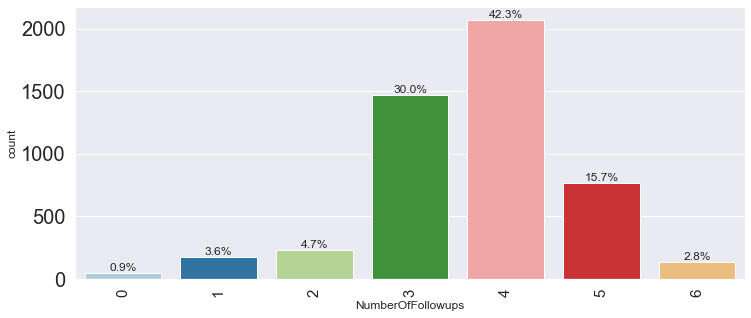

<IPython.core.display.Javascript object>

In [39]:
labeled_barplot(data, "NumberOfFollowups", perc=True)

For most of the customers there were 3, 4 or 5 follow ups

### ProductPitched
Lets look at the distribution of the ProductPitched

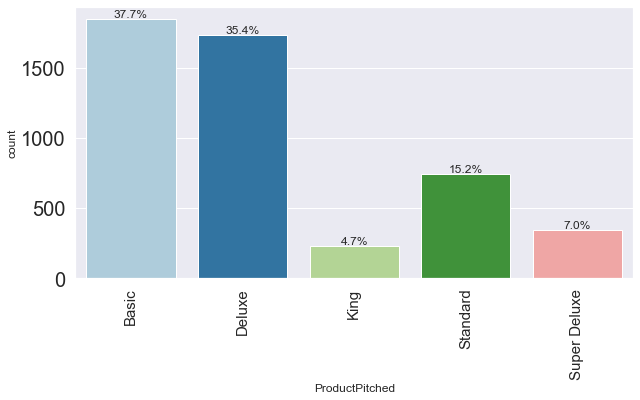

<IPython.core.display.Javascript object>

In [40]:
labeled_barplot(data, "ProductPitched", perc=True)

Most of the customers were pitched th Basic, Deluxe or Standard package.<br>
Les than 10% customers were each pitched King or Super Deluxe packages

### PreferredPropertyStar
Let's look at the distribution of PreferredPropertyStar

In [41]:
data["PreferredPropertyStar"].value_counts(dropna=False)

3.0    2993
5.0     956
4.0     913
NaN      26
Name: PreferredPropertyStar, dtype: int64

<IPython.core.display.Javascript object>

There are 26 Null or missing values in PreferredPropertyStar<br>
We will be imputing the Null values with the Mode

In [42]:
data["PreferredPropertyStar"].fillna(data["PreferredPropertyStar"].mode(), inplace=True)

<IPython.core.display.Javascript object>

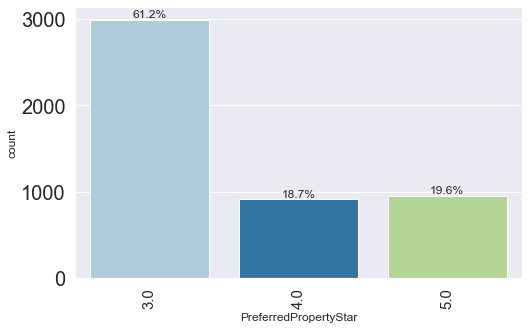

<IPython.core.display.Javascript object>

In [43]:
labeled_barplot(data, "PreferredPropertyStar", perc=True)

* 63.2% customers prefer 3 star property
* 18.7% customers prefer 4 star property
* 19.6% customers prefer 5 star property

### MaritalStatus
Let's look at the distribution of MaritalStatus

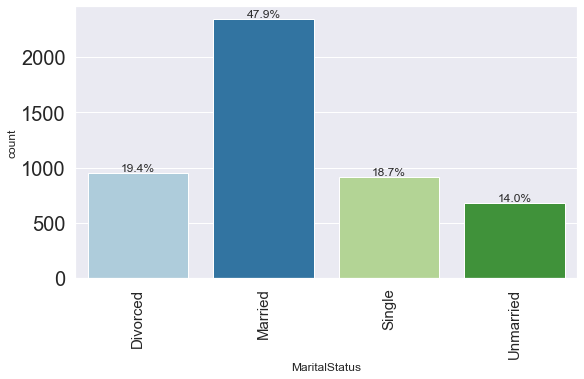

<IPython.core.display.Javascript object>

In [44]:
labeled_barplot(data, "MaritalStatus", perc=True)

There are no missing or null values in MaritalStatus<br>
As expected most number of customers are Married

### NumberOfTrips
Let's take a look at the NumberOfTrips data

In [45]:
data["NumberOfTrips"].value_counts(dropna=False)

2.0     1464
3.0     1079
1.0      620
4.0      478
5.0      458
6.0      322
7.0      218
NaN      140
8.0      105
19.0       1
20.0       1
21.0       1
22.0       1
Name: NumberOfTrips, dtype: int64

<IPython.core.display.Javascript object>

* There are 140 Null values for NumberOfTrips
* only one row each with NumberOfTrips 19, 20 , 21, 22. This looks like an error in the entry. we should replace these values with the 1st digit of the number
* This being a categorical column we should impute the Nulls with the Mode

In [46]:
data["NumberOfTrips"] = data["NumberOfTrips"].astype("float64")
data["NumberOfTrips"].replace(
    [19.0, 20.0, 21.0, 22.0], [1.0, 2.0, 2.0, 2.0], inplace=True
)
data["NumberOfTrips"].fillna(data["NumberOfTrips"].mode(), inplace=True)
data["NumberOfTrips"] = data["NumberOfTrips"].astype("category")

<IPython.core.display.Javascript object>

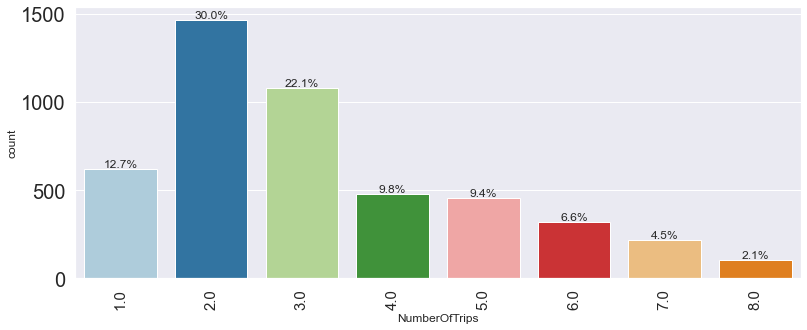

<IPython.core.display.Javascript object>

In [47]:
labeled_barplot(data, "NumberOfTrips", perc=True)

* Most customers do 2 to 3 trips per year
* Some customers do 4 to 6 trips per year
* Few customers do 7 or 8 trips per year

### Passport
Lets look at the data distribution for Passport

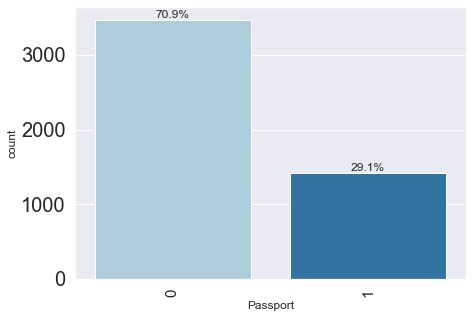

<IPython.core.display.Javascript object>

In [48]:
labeled_barplot(data, "Passport", perc=True)

70.9% customers don't have a Passport whereas 29.1% do.

### PitchSatisfactionScore
Lets look at the PitchSatisfactionScore data

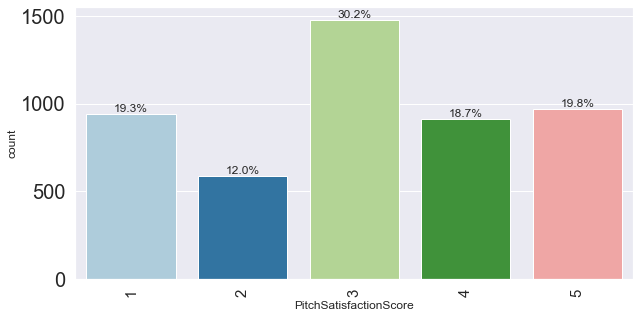

<IPython.core.display.Javascript object>

In [49]:
labeled_barplot(data, "PitchSatisfactionScore", perc=True)

There seems to be an almost even distribution of the PitchSatisfactionScore values

### OwnCar
Lets look at the OwnCar distribution

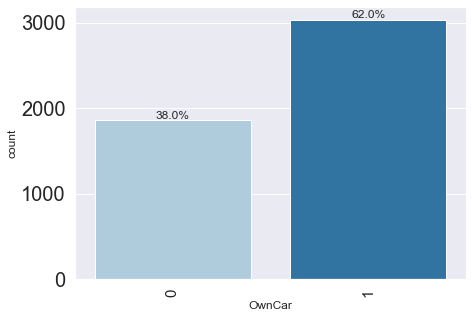

<IPython.core.display.Javascript object>

In [50]:
labeled_barplot(data, "OwnCar", perc=True)

62% customers own a car and 38% don't


### NumberOfChildrenVisiting
Let's take a look at NumberOfChildrenVisiting data

In [51]:
data["NumberOfChildrenVisiting"].value_counts(dropna=False)

1.0    2080
2.0    1335
0.0    1082
3.0     325
NaN      66
Name: NumberOfChildrenVisiting, dtype: int64

<IPython.core.display.Javascript object>

There are 66 Null or missing values for NumberOfChildrenVisiting. It is safe to assume 0 for these cases

In [52]:
data["NumberOfChildrenVisiting"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

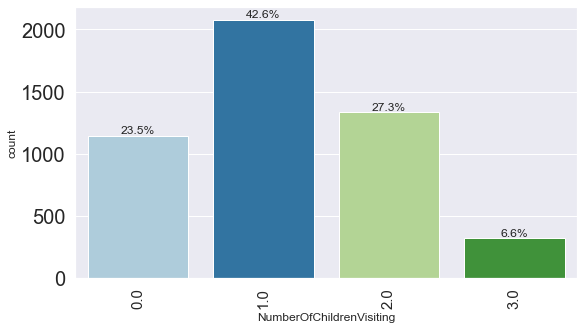

<IPython.core.display.Javascript object>

In [53]:
labeled_barplot(data, "NumberOfChildrenVisiting", perc=True)

* 23.5% customers are visiting without any children
* 42.6% customers are visiting with 1 child
* 27.3% with 2 children and
* 6.6% with 3 children

### Designation
Lets take a look at Designation distribution

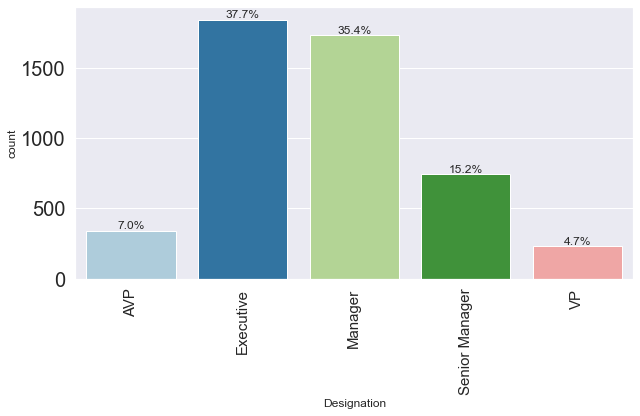

<IPython.core.display.Javascript object>

In [54]:
labeled_barplot(data, "Designation", perc=True)

Most of the customers are at Executive or Manager levels

### MonthlyIncome
Lets take a look at MonthlyIncome data
<br>
We have seen that there are 233 Null values in MonthlyIncome

In [55]:
data["MonthlyIncome"].isna().sum()

233

<IPython.core.display.Javascript object>

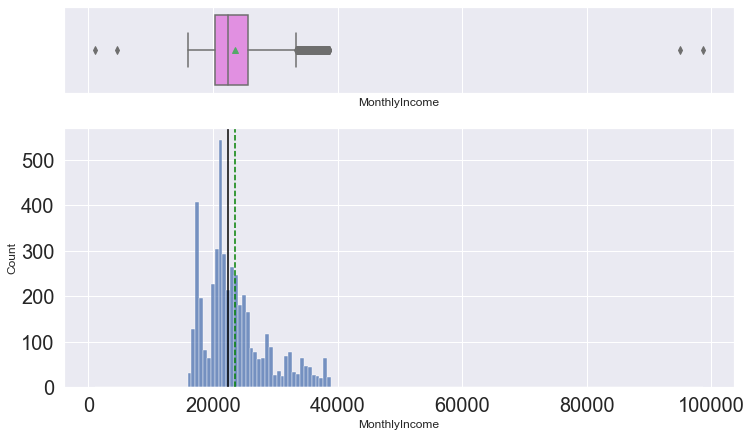

<IPython.core.display.Javascript object>

In [56]:
histogram_boxplot(data, "MonthlyIncome")

In [57]:
data["MonthlyIncome"].sort_values().head()

142      1000.0
2586     4678.0
513     16009.0
1983    16009.0
2197    16051.0
Name: MonthlyIncome, dtype: float64

<IPython.core.display.Javascript object>

In [58]:
data["MonthlyIncome"].sort_values().tail()

2390   NaN
2399   NaN
2410   NaN
2430   NaN
2431   NaN
Name: MonthlyIncome, dtype: float64

<IPython.core.display.Javascript object>

MonthlyIncome data is almost evenly distributed with outliers on both the sides. Both those outliers could be actual values<br>
Outlies should nit cause any porblems in the classification problem.

Conisdering the distribution of MonthlyIncome we should impute the null values with median

In [59]:
data["MonthlyIncome"].fillna(data["MonthlyIncome"].median(), inplace=True)

<IPython.core.display.Javascript object>

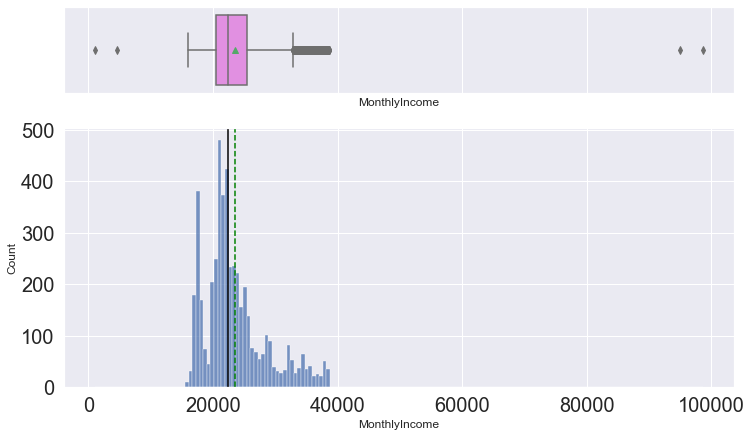

<IPython.core.display.Javascript object>

In [60]:
histogram_boxplot(data, "MonthlyIncome")

## Bivariate Analysis

Lets take a look at the correlations between the non-categorical columns

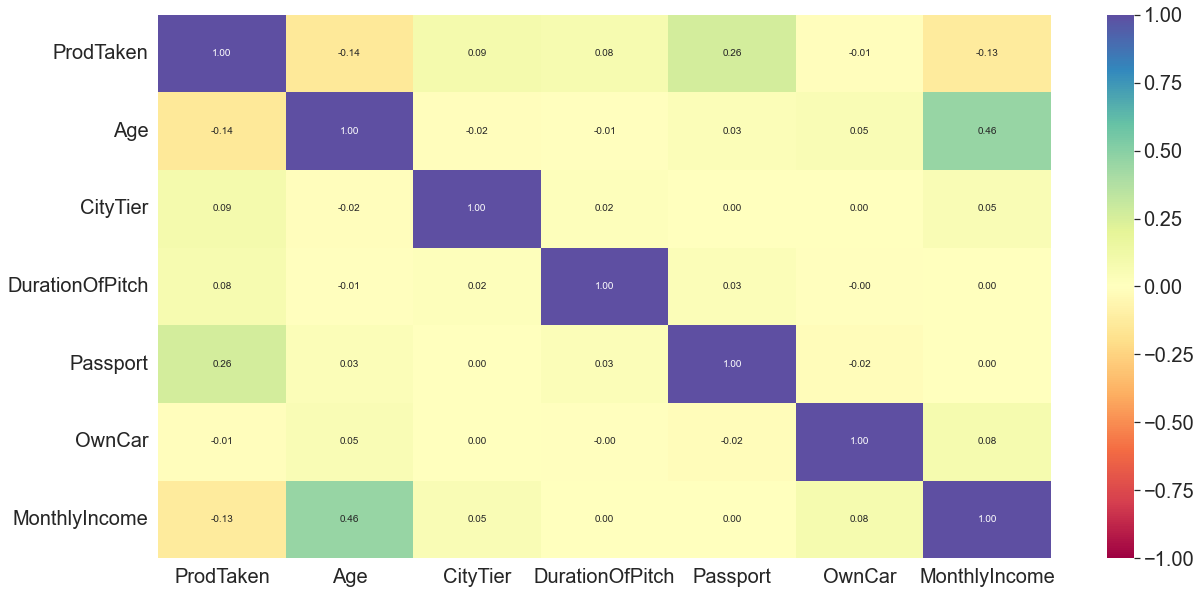

<IPython.core.display.Javascript object>

In [61]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

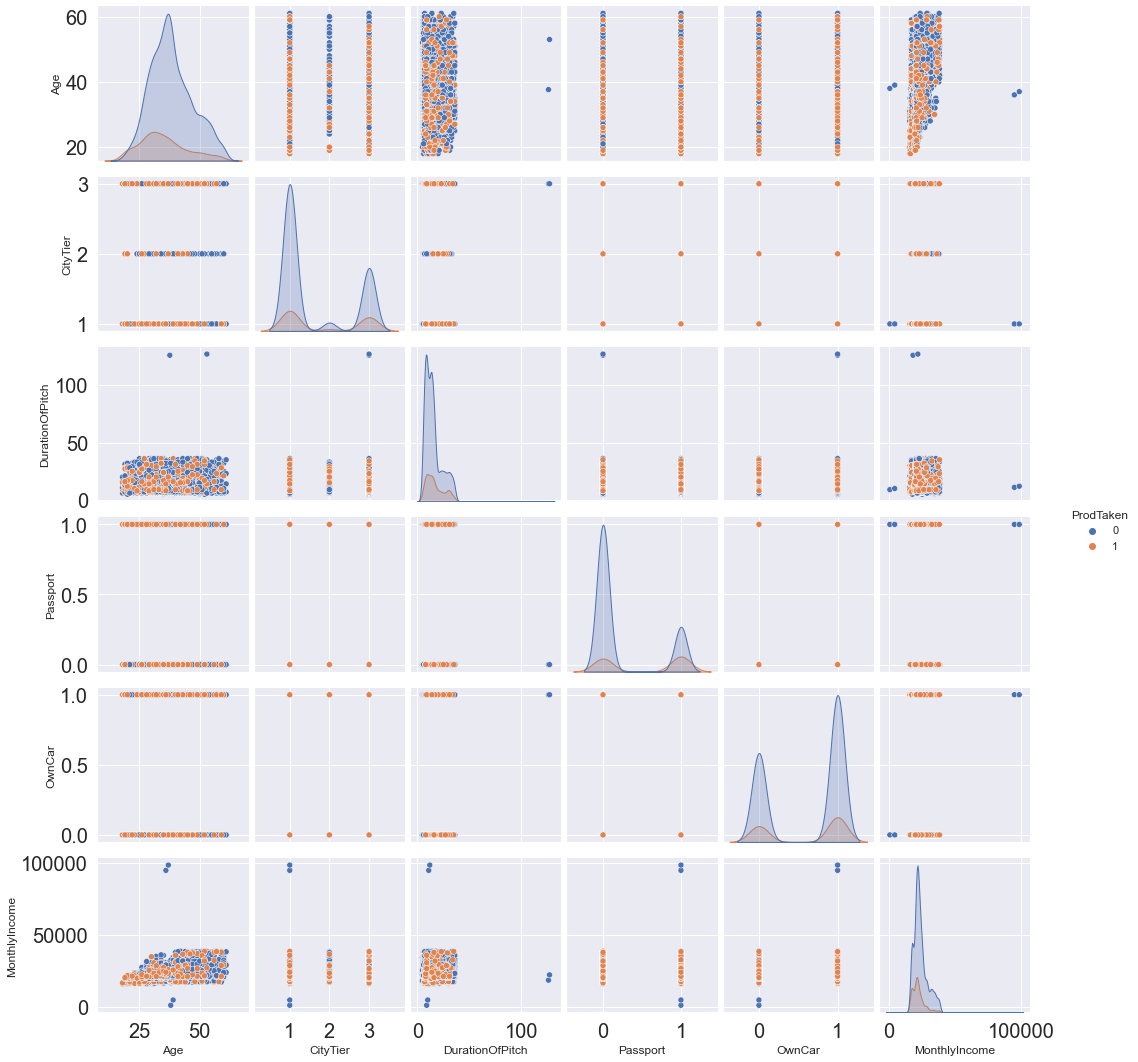

<IPython.core.display.Javascript object>

In [62]:
sns.pairplot(data, hue="ProdTaken")
plt.show()

There is no strong correlations between any of the non-categorical variables

In [63]:
# Function ot plot Labled barplot and stacked barplot for the category with target
def barplots_for_cat(cat_col, target="ProdTaken"):
    labeled_barplot(data=data, feature=cat_col, hue="ProdTaken", perc=True)
    stacked_barplot(data=data, predictor=cat_col, target="ProdTaken")

<IPython.core.display.Javascript object>

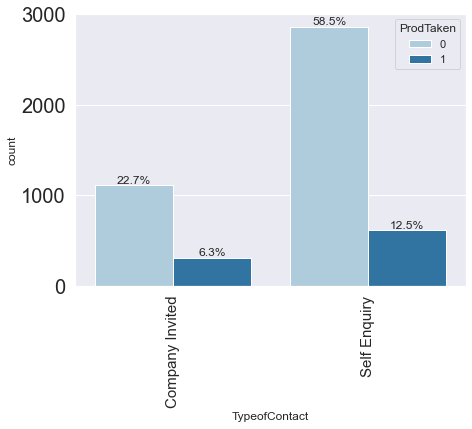

ProdTaken           0    1   All
TypeofContact                   
All              3968  920  4888
Self Enquiry     2859  610  3469
Company Invited  1109  310  1419
---------------------------------------------------------------------------


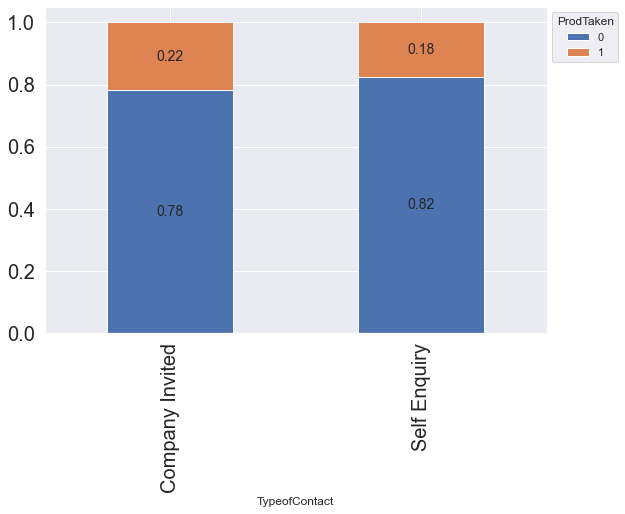

<IPython.core.display.Javascript object>

In [64]:
# TypeofContact and ProdTaken:
barplots_for_cat("TypeofContact")

* 22% Company Invited Customers bought the package
* 18% Self Inquiry Customers bought the package 
There is not a clear correlation of TypeofContatc to ProductTaken 

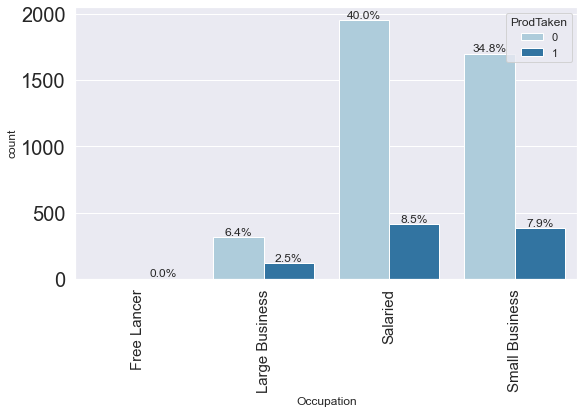

ProdTaken          0    1   All
Occupation                     
All             3968  920  4888
Salaried        1954  414  2368
Small Business  1700  384  2084
Large Business   314  120   434
Free Lancer        0    2     2
---------------------------------------------------------------------------


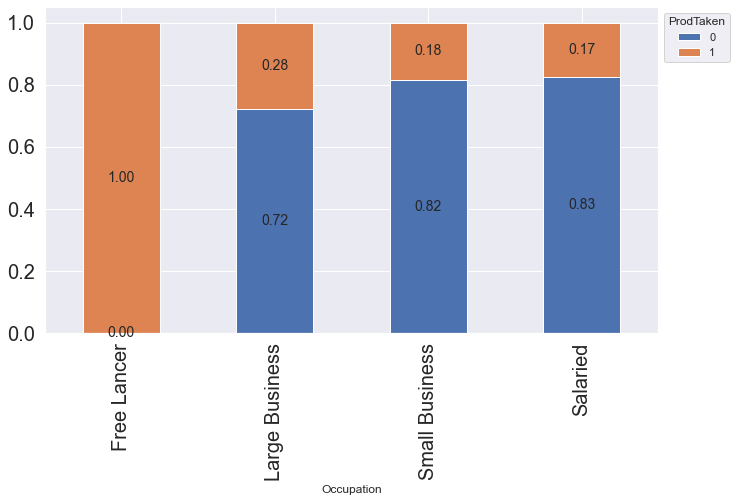

<IPython.core.display.Javascript object>

In [65]:
# Occupation and ProdTaken:
barplots_for_cat("Occupation")

* All of the free Lancers bought the package but there are only 2 of them
* Larger proportion of large business owners have purchased the product

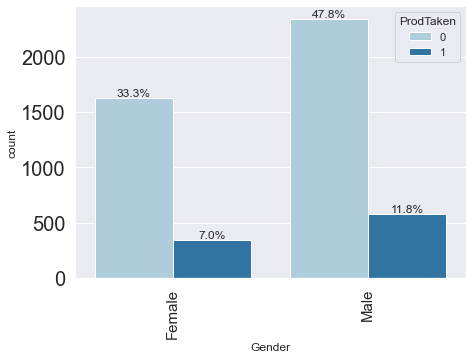

ProdTaken     0    1   All
Gender                    
All        3968  920  4888
Male       2338  578  2916
Female     1630  342  1972
---------------------------------------------------------------------------


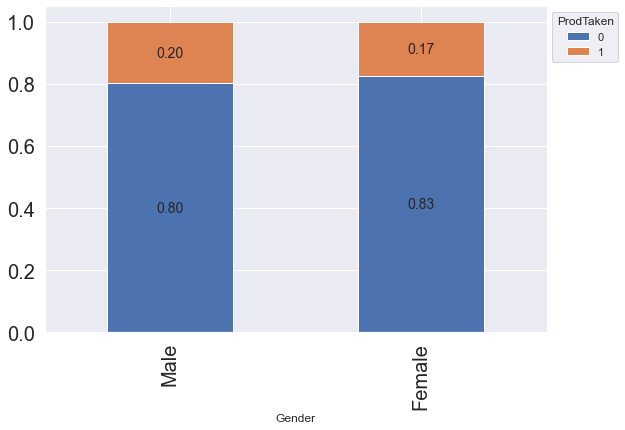

<IPython.core.display.Javascript object>

In [66]:
# Gender and ProdTaken:
barplots_for_cat("Gender")

20% of the total Male customers purchased th product<br>
17% of the total Female customers purchased the product

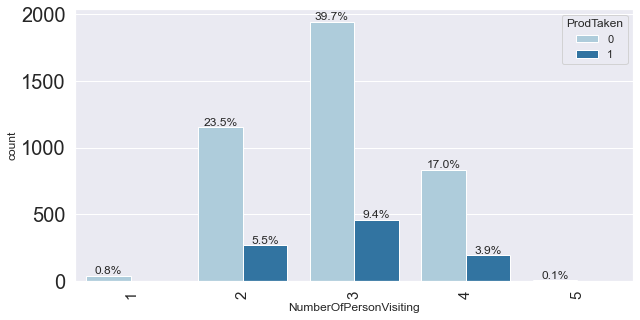

ProdTaken                  0    1   All
NumberOfPersonVisiting                 
All                     3968  920  4888
3                       1942  460  2402
2                       1151  267  1418
4                        833  193  1026
1                         39    0    39
5                          3    0     3
---------------------------------------------------------------------------


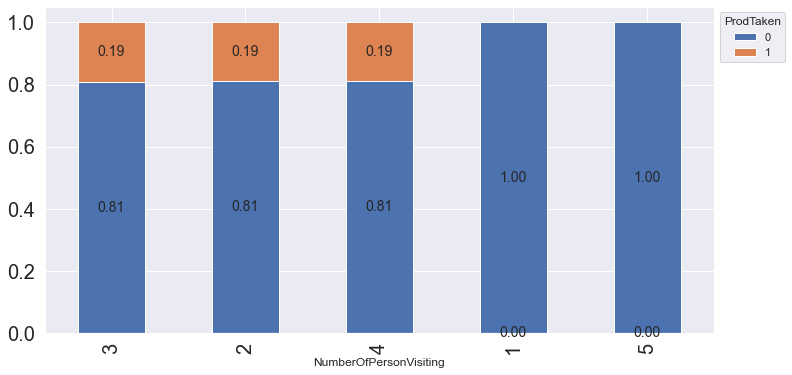

<IPython.core.display.Javascript object>

In [67]:
# NumberOfPersonVisiting and ProdTaken:
barplots_for_cat("NumberOfPersonVisiting")

* None of the customers with 1 or 5 visitors have purchased the product
* 19% customes with 2, 3 or 4 visitors have purchased the product

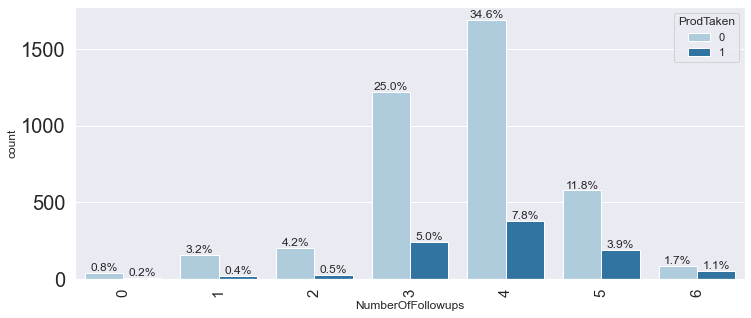

ProdTaken             0    1   All
NumberOfFollowups                 
All                3968  920  4888
4                  1689  379  2068
3                  1222  244  1466
5                   577  191   768
6                    82   54   136
2                   205   24   229
1                   156   20   176
0                    37    8    45
---------------------------------------------------------------------------


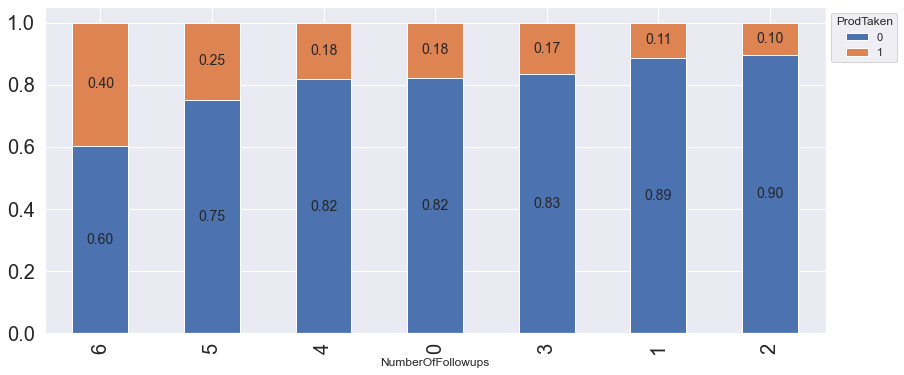

<IPython.core.display.Javascript object>

In [68]:
# NumberOfFollowups and ProdTaken:
barplots_for_cat("NumberOfFollowups")

More number of follow ups are resulting in more customers purchasing the product

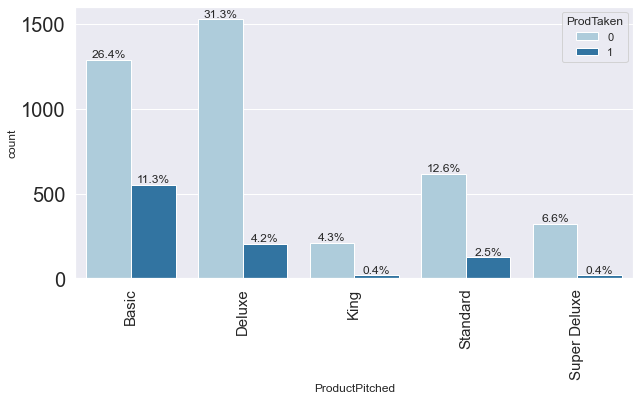

ProdTaken          0    1   All
ProductPitched                 
All             3968  920  4888
Basic           1290  552  1842
Deluxe          1528  204  1732
Standard         618  124   742
King             210   20   230
Super Deluxe     322   20   342
---------------------------------------------------------------------------


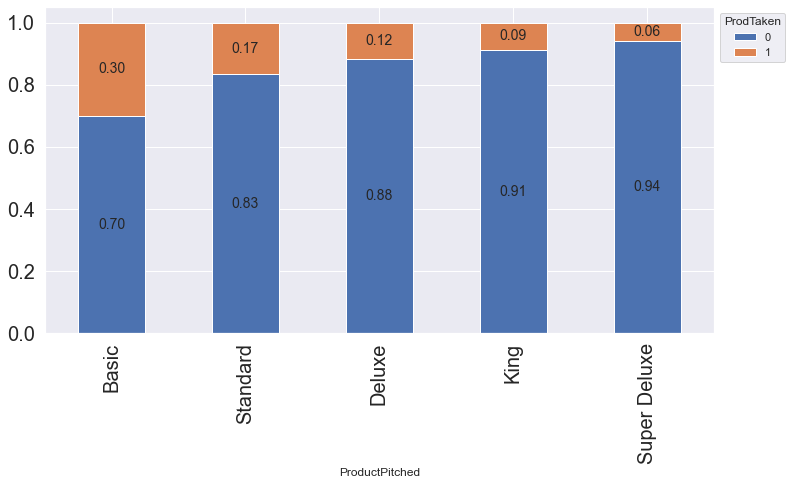

<IPython.core.display.Javascript object>

In [69]:
# ProductPitched and ProdTaken:
barplots_for_cat("ProductPitched")

more percentage of Customers who were pitched the Basic package have bought the product

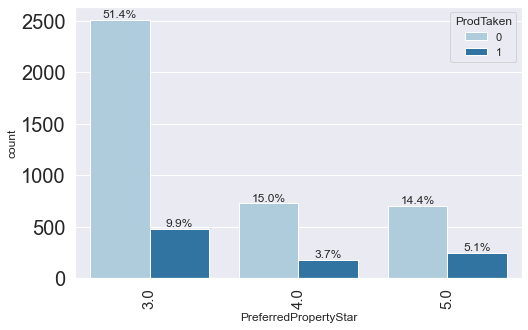

ProdTaken                 0    1   All
PreferredPropertyStar                 
All                    3948  914  4862
3.0                    2511  482  2993
5.0                     706  250   956
4.0                     731  182   913
---------------------------------------------------------------------------


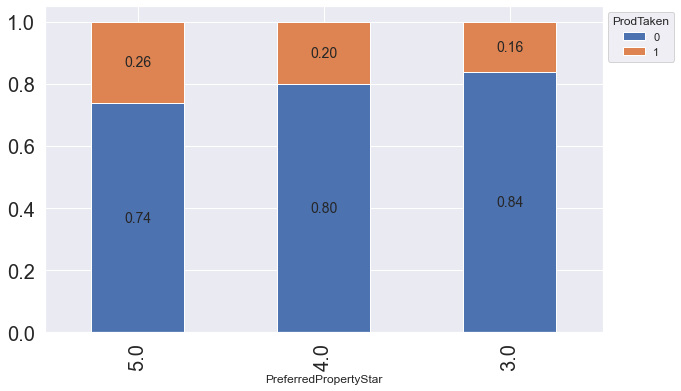

<IPython.core.display.Javascript object>

In [70]:
# PreferredPropertyStar and ProdTaken:
barplots_for_cat("PreferredPropertyStar")

* 26% of customers preferring 5 star properties have bought the product
* 20% of customers preferring 4 star properties have bought the product
* 16% of customers preferring 3 star properties have bought the product

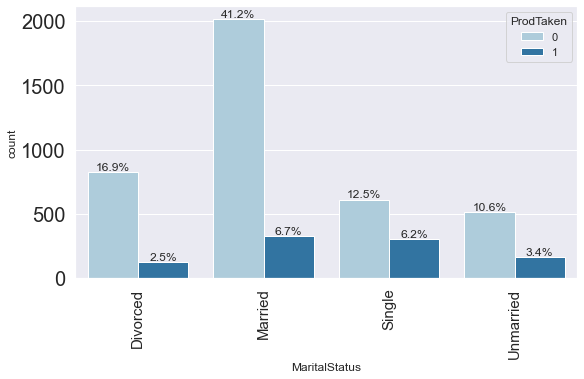

ProdTaken         0    1   All
MaritalStatus                 
All            3968  920  4888
Married        2014  326  2340
Single          612  304   916
Unmarried       516  166   682
Divorced        826  124   950
---------------------------------------------------------------------------


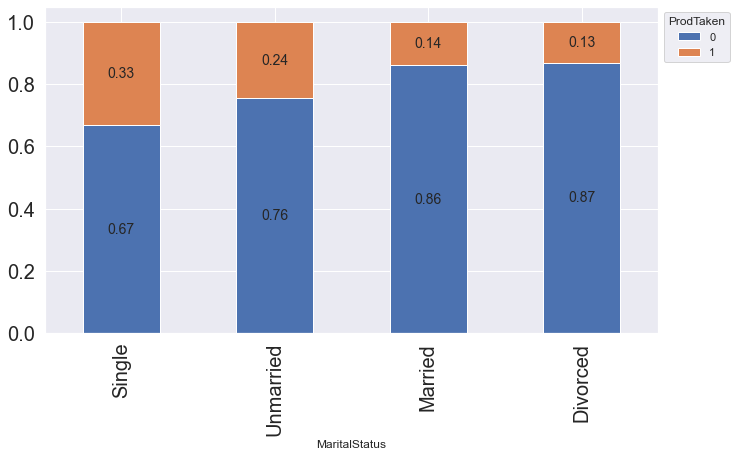

<IPython.core.display.Javascript object>

In [71]:
# MaritalStatus and ProdTaken:
barplots_for_cat("MaritalStatus")

Higher percentage of Single or Unmarried customers have bought the product

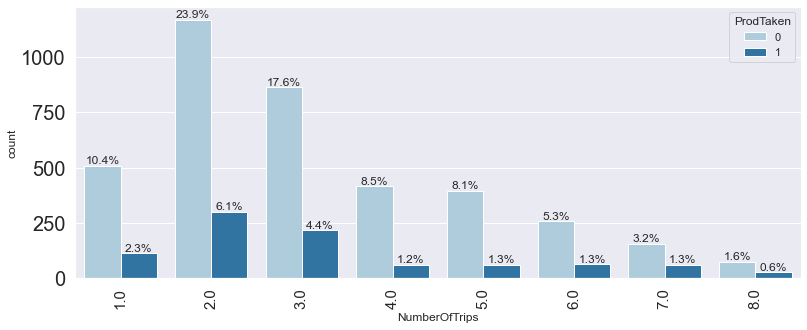

ProdTaken         0    1   All
NumberOfTrips                 
All            3840  908  4748
2.0            1167  300  1467
3.0             862  217  1079
1.0             508  113   621
6.0             258   64   322
5.0             396   62   458
7.0             156   62   218
4.0             417   61   478
8.0              76   29   105
---------------------------------------------------------------------------


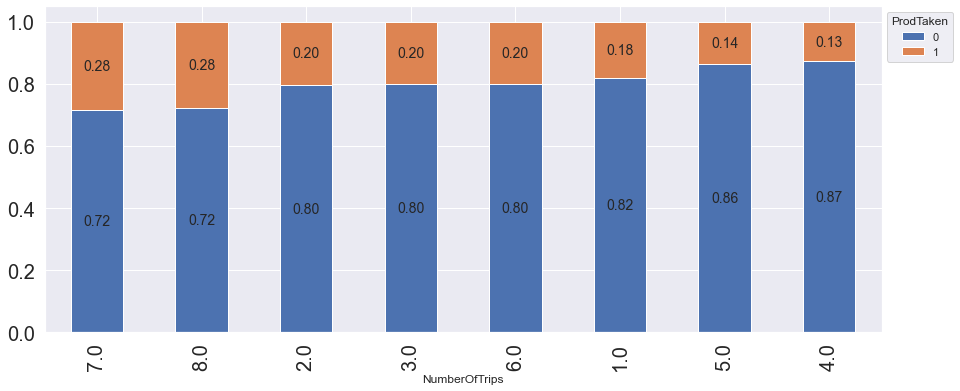

<IPython.core.display.Javascript object>

In [72]:
# NumberOfTrips and ProdTaken:
barplots_for_cat("NumberOfTrips")

Customers who make 7 or 8 trips per year have bought the package more than others

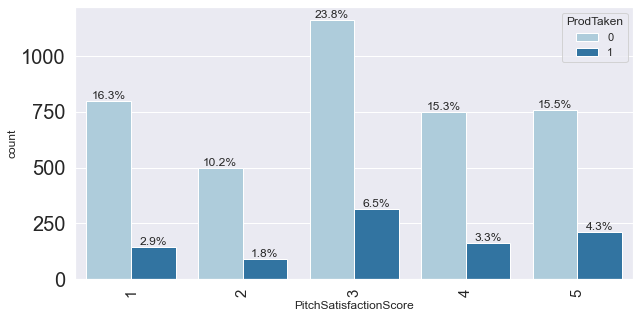

ProdTaken                  0    1   All
PitchSatisfactionScore                 
All                     3968  920  4888
3                       1162  316  1478
5                        760  210   970
4                        750  162   912
1                        798  144   942
2                        498   88   586
---------------------------------------------------------------------------


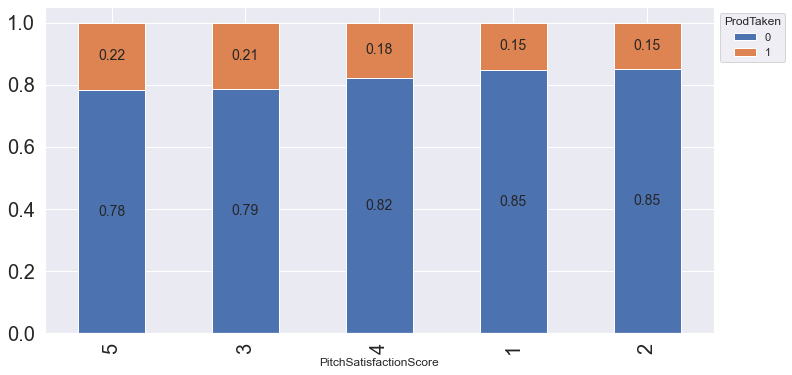

<IPython.core.display.Javascript object>

In [73]:
# PitchSatisfactionScore and ProdTaken:
barplots_for_cat("PitchSatisfactionScore")

Most customers rated the pitch a score of 3 and 18% of those bought the product<br>
Even thought some customers rated the pitch 1 or 2, still 15% of each of those have bought the product.<br>
PitchSatisfictionScore does not seem to have a very strong impact on the product purchasing decision.

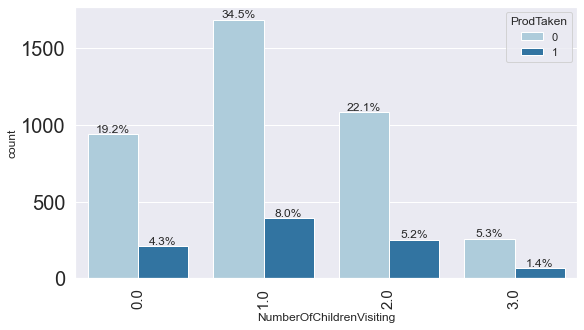

ProdTaken                    0    1   All
NumberOfChildrenVisiting                 
All                       3968  920  4888
1.0                       1688  392  2080
2.0                       1082  253  1335
0.0                        939  209  1148
3.0                        259   66   325
---------------------------------------------------------------------------


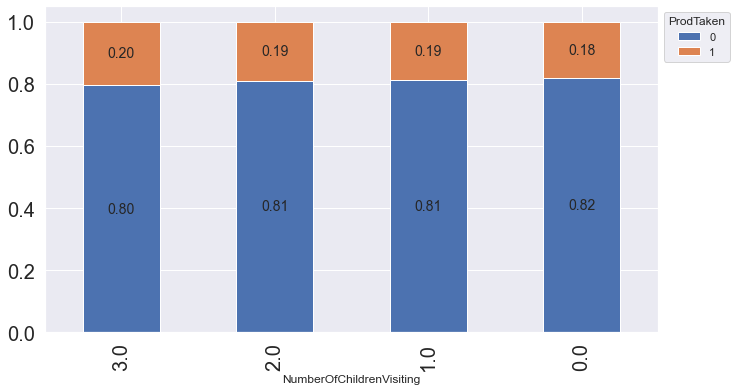

<IPython.core.display.Javascript object>

In [74]:
# NumberOfChildrenVisiting and ProdTaken:
barplots_for_cat("NumberOfChildrenVisiting")

All the groups by number of children visiting show 18 to 20 % purchases.<br>
NumberofChildrenVisiting does not seem to have any strong impact on the decision to purchase the product

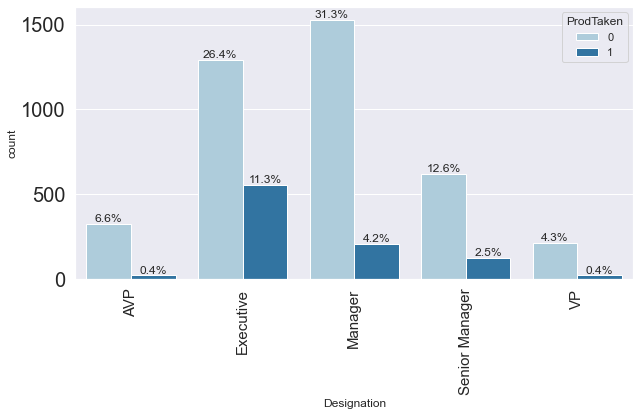

ProdTaken          0    1   All
Designation                    
All             3968  920  4888
Executive       1290  552  1842
Manager         1528  204  1732
Senior Manager   618  124   742
AVP              322   20   342
VP               210   20   230
---------------------------------------------------------------------------


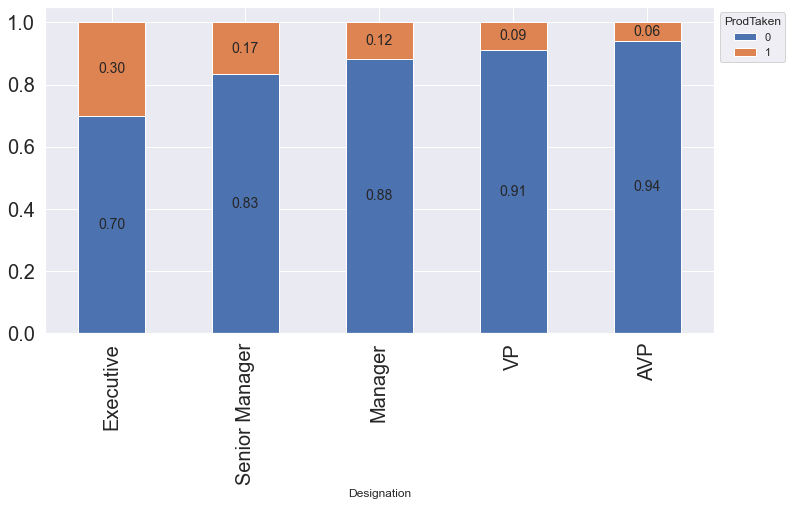

<IPython.core.display.Javascript object>

In [75]:
# Designation and ProdTaken:
barplots_for_cat("Designation")

* 30% of the Executive customers purchased the product
* 17% of the Senior Manager customers purchased the product
* most of the VP and AVP customers did not purchase the product

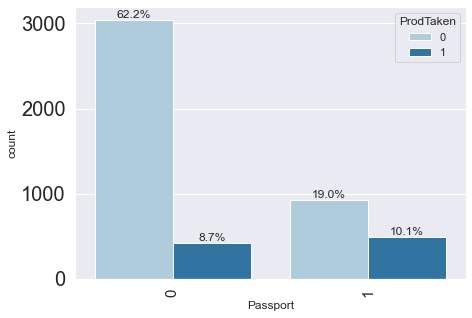

ProdTaken     0    1   All
Passport                  
All        3968  920  4888
1           928  494  1422
0          3040  426  3466
---------------------------------------------------------------------------


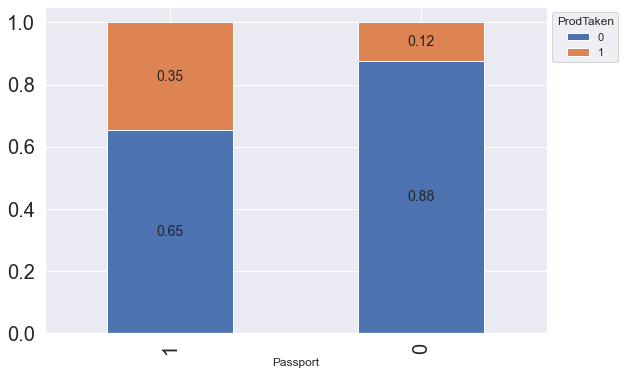

<IPython.core.display.Javascript object>

In [76]:
# Passport and ProdTaken:
barplots_for_cat("Passport")

More customers do not have a passport<br>
But a higher percentage of customers who have a passport purchased the product

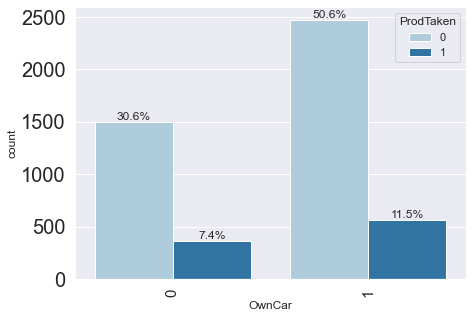

ProdTaken     0    1   All
OwnCar                    
All        3968  920  4888
1          2472  560  3032
0          1496  360  1856
---------------------------------------------------------------------------


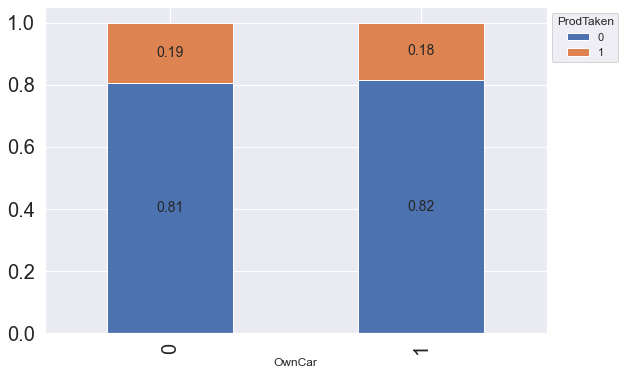

<IPython.core.display.Javascript object>

In [77]:
# OwnCar and ProdTaken:
barplots_for_cat("OwnCar")

Owning a car does not seem to impact the decision of purchasing the product

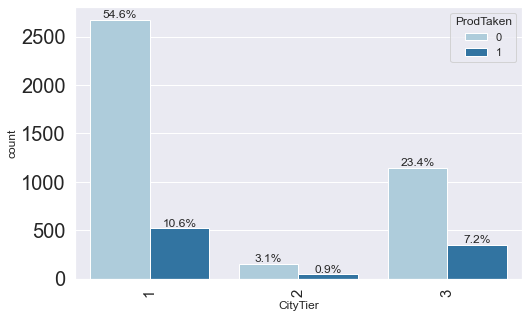

ProdTaken     0    1   All
CityTier                  
All        3968  920  4888
1          2670  520  3190
3          1146  354  1500
2           152   46   198
---------------------------------------------------------------------------


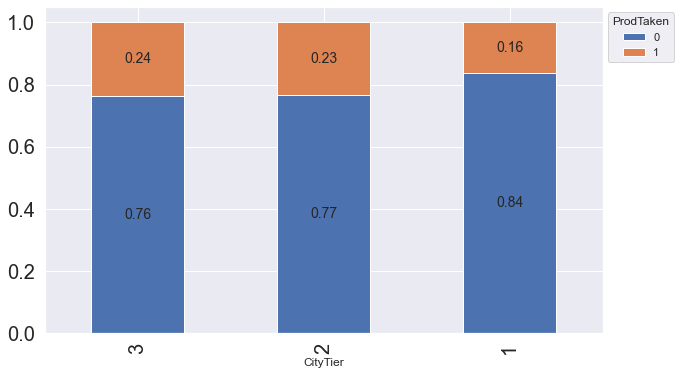

<IPython.core.display.Javascript object>

In [78]:
# CityTier and ProdTaken:
barplots_for_cat("CityTier")

Maximum number of customers are from Tier 1 cities<br>
But a higher percentage of the customers from Tier one or Tier 2 cities purchased the product

### Analysis of Customer data for purchased products

In [79]:
# DF for only the purchased items
purchesed_df = data.loc[data["ProdTaken"] == 1]
purchesed_df = purchesed_df.drop("ProdTaken", axis=1)
purchesed_df["Passport"] = purchesed_df["Passport"].astype("category")
purchesed_df["OwnCar"] = purchesed_df["OwnCar"].astype("category")
purchesed_df["CityTier"] = purchesed_df["CityTier"].astype("category")

<IPython.core.display.Javascript object>

In [80]:
purchesed_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,920.0,34.906934,9.843365,18.0,28.00,33.0,41.0,60.0
DurationOfPitch,920.0,16.683696,8.305049,6.0,10.00,15.0,23.0,36.0
MonthlyIncome,920.0,22178.885870,4567.349943,16009.0,18475.25,21274.0,23857.5,38537.0


<IPython.core.display.Javascript object>

In [81]:
purchesed_df.describe(include="category").T

,count,unique,top,freq
TypeofContact,920,2,Self Enquiry,610
CityTier,920,3,1,520
Occupation,920,4,Salaried,414
Gender,920,2,Male,578
NumberOfPersonVisiting,920,3,3,460
NumberOfFollowups,920,7,4,379
ProductPitched,920,5,Basic,552
PreferredPropertyStar,914.0,3.0,3.0,482.0
MaritalStatus,920,4,Married,326
NumberOfTrips,908.0,8.0,2.0,300.0


<IPython.core.display.Javascript object>

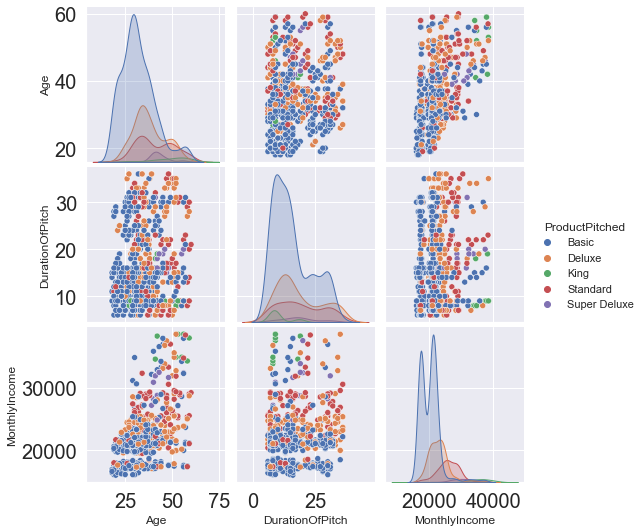

<IPython.core.display.Javascript object>

In [82]:
sns.pairplot(purchesed_df, hue="ProductPitched")

In [83]:
# Basic:
basic_df = purchesed_df.loc[purchesed_df["ProductPitched"] == "Basic"]
basic_df = basic_df.drop("ProductPitched", axis=1)

<IPython.core.display.Javascript object>

In [84]:
basic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,552.0,31.713811,8.903226,18.0,26.00,30.0,37.0,59.0
DurationOfPitch,552.0,15.690217,7.779636,6.0,9.00,13.5,21.0,36.0
MonthlyIncome,552.0,20252.590580,3272.722428,16009.0,17581.25,20722.0,21529.5,37868.0


<IPython.core.display.Javascript object>

In [85]:
basic_df.describe(include="category").T

,count,unique,top,freq
TypeofContact,552,2,Self Enquiry,358
CityTier,552,3,1,392
Occupation,552,4,Salaried,260
Gender,552,2,Male,344
NumberOfPersonVisiting,552,3,3,276
NumberOfFollowups,552,7,4,235
PreferredPropertyStar,552.0,3.0,3.0,282.0
MaritalStatus,552,4,Single,230
NumberOfTrips,547.0,8.0,2.0,199.0
Passport,552,2,1,322


<IPython.core.display.Javascript object>

### Customer Profile for Basic Package

* Designation Executive
* City Tier 1
* Self Enquiry
* Male
* Has Passport
* Owns a car
* Salaried
* Age less than 35
* Single
* Monthly Income 20K to 30K
* Number of persons visiting 3

In [86]:
# Deluxe:
Delux_df = purchesed_df.loc[purchesed_df["ProductPitched"] == "Deluxe"]
Delux_df = Delux_df.drop("ProductPitched", axis=1)

<IPython.core.display.Javascript object>

In [87]:
Delux_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,204.0,37.640851,8.343471,21.0,32.0,36.0,43.25,59.0
DurationOfPitch,204.0,18.382353,8.885749,6.0,12.0,15.0,26.00,36.0
MonthlyIncome,204.0,23072.720588,3515.404275,17086.0,20764.0,22911.0,24455.00,38525.0


<IPython.core.display.Javascript object>

In [88]:
Delux_df.describe(include="category").T

,count,unique,top,freq
TypeofContact,204,2,Self Enquiry,136
CityTier,204,2,3,144
Occupation,204,3,Small Business,108
Gender,204,2,Male,134
NumberOfPersonVisiting,204,3,3,102
NumberOfFollowups,204,7,4,78
PreferredPropertyStar,203.0,3.0,3.0,114.0
MaritalStatus,204,4,Married,68
NumberOfTrips,202.0,8.0,2.0,49.0
Passport,204,2,0,104


<IPython.core.display.Javascript object>

### Customer profile for Deluxe Package
* Designation Manager 
* Self Enquiry
* City Tier 3
* Male
* Age 35 to 42
* Married
* Occupation Small Business
* Does not have passport
* Owns a car

In [89]:
# King:
King_df = purchesed_df.loc[purchesed_df["ProductPitched"] == "King"]
King_df = King_df.drop("ProductPitched", axis=1)

<IPython.core.display.Javascript object>

In [90]:
King_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,20.0,48.9,9.618513,27.0,42.00,52.5,56.0,59.0
DurationOfPitch,20.0,10.5,4.135851,8.0,8.00,9.0,9.0,19.0
MonthlyIncome,20.0,34672.1,5577.603833,17517.0,34470.25,34859.0,38223.0,38537.0


<IPython.core.display.Javascript object>

In [91]:
King_df.describe(include="category").T

,count,unique,top,freq
TypeofContact,20,1,Self Enquiry,20
CityTier,20,2,1,12
Occupation,20,3,Small Business,12
Gender,20,2,Female,12
NumberOfPersonVisiting,20,3,3,10
NumberOfFollowups,20,4,3,6
PreferredPropertyStar,16.0,3.0,4.0,8.0
MaritalStatus,20,3,Single,8
NumberOfTrips,17.0,6.0,3.0,6.0
Passport,20,2,1,12


<IPython.core.display.Javascript object>

### Customer profile for King Package
* Designation VP
* Self Enquiry
* Age 45 to 50
* Monthly In come 34K to 39K
* Female
* Occupation Small Business
* City Tier 1
* Has Passport
* Owns a car
* prefers 4 star property

In [92]:
# Standard:
Standard_df = purchesed_df.loc[purchesed_df["ProductPitched"] == "Standard"]
Standard_df = Standard_df.drop("ProductPitched", axis=1)

<IPython.core.display.Javascript object>

In [93]:
Standard_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,124.0,40.980825,9.841163,19.0,33.00,38.0,49.0,60.0
DurationOfPitch,124.0,19.016129,9.028396,6.0,11.00,17.0,29.0,36.0
MonthlyIncome,124.0,26035.419355,3593.290353,17372.0,23974.75,25711.0,28628.0,38395.0


<IPython.core.display.Javascript object>

In [94]:
Standard_df.describe(include="category").T

,count,unique,top,freq
TypeofContact,124,2,Self Enquiry,92
CityTier,124,3,3,64
Occupation,124,3,Small Business,58
Gender,124,2,Male,76
NumberOfPersonVisiting,124,3,3,62
NumberOfFollowups,124,6,4,56
PreferredPropertyStar,123.0,3.0,3.0,68.0
MaritalStatus,124,4,Married,56
NumberOfTrips,123.0,8.0,2.0,42.0
Passport,124,2,0,76


<IPython.core.display.Javascript object>

### Customer Profile for Standard package
* Designation: Senior Manager
* Self Enquiry
* Age 35 to 40 years
* Monthly Income 22K to 25K
* City Tier 3
* Married
* Male
* Prefers 3 star property
* Occupation: Small Business
* Has Passoprt
* Owns a car

In [95]:
# Super Deluxe:
Super_Deluxe_df = purchesed_df.loc[purchesed_df["ProductPitched"] == "Super Deluxe"]
Super_Deluxe_df = Super_Deluxe_df.drop("ProductPitched", axis=1)

<IPython.core.display.Javascript object>

In [96]:
Super_Deluxe_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,20.0,43.5,4.839530,39.0,40.0,42.0,45.25,56.0
DurationOfPitch,20.0,18.5,7.330542,8.0,15.0,18.5,20.00,31.0
MonthlyIncome,20.0,29823.8,3520.426404,21151.0,28129.5,29802.5,31997.25,37502.0


<IPython.core.display.Javascript object>

In [97]:
Super_Deluxe_df.describe(include="category").T

,count,unique,top,freq
TypeofContact,20,2,Company Invited,16
CityTier,20,2,3,16
Occupation,20,2,Salaried,16
Gender,20,2,Male,16
NumberOfPersonVisiting,20,3,3,10
NumberOfFollowups,20,6,1,4
PreferredPropertyStar,20.0,3.0,3.0,12.0
MaritalStatus,20,3,Single,10
NumberOfTrips,19.0,6.0,1.0,6.0
Passport,20,2,1,12


<IPython.core.display.Javascript object>

### Customer Profile for Super Deluxe package
* Designation AVP
* Age 40 to 45 years
* Monthly Income 28K to 32K
* Owns a car
* Has Passport
* Company Invited
* Male
* Single
* Occupation: Salaried
* City Tier 3
* Prefers 3 star property

### Summary of EDA
#### Data Description
- There are 4888 rows and 20 columns in the original dataset
- 14 Numeric columns (7 float and 7 int) And 6 object columns
- Some categorical columns were treated as numeric. We analyzed each of those individually and converted category. 
  * ProdTaken, Passport & OwnCar were not converted to categories as they only have 1 and 0 values
  * CityTier was not converted to category because the values are ordered
- Some columns had null or missing values. We analyzed each of those independently and imputed with appropriate values
- Some columns had outliers. 
    * Outliers were mostly ignored as those looked like correct values and this being a classification problem outliers should not affect much
    * for NumberofTrips Outliers were replaced with appropriate values where they seemed to be because of typing error


## Model Building 

### Data preparation
We have already take care of the outliers and null values in the data.<br>
We will be now replacing the categorical columns with dummies

In [98]:
data = pd.get_dummies(data=data, drop_first=True)
data.sample(10)

,ProdTaken,Age,CityTier,DurationOfPitch,Passport,OwnCar,MonthlyIncome,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_Male,NumberOfPersonVisiting_2,NumberOfPersonVisiting_3,NumberOfPersonVisiting_4,NumberOfPersonVisiting_5,NumberOfFollowups_1,NumberOfFollowups_2,NumberOfFollowups_3,NumberOfFollowups_4,NumberOfFollowups_5,NumberOfFollowups_6,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Unmarried,NumberOfTrips_2.0,NumberOfTrips_3.0,NumberOfTrips_4.0,NumberOfTrips_5.0,NumberOfTrips_6.0,NumberOfTrips_7.0,NumberOfTrips_8.0,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4,PitchSatisfactionScore_5,NumberOfChildrenVisiting_1.0,NumberOfChildrenVisiting_2.0,NumberOfChildrenVisiting_3.0,Designation_Executive,Designation_Manager,Designation_Senior Manager,Designation_VP
393,0,34.0,3,10.0,0,1,21538.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4874,1,42.0,1,15.0,1,0,22781.0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
4470,0,54.0,1,13.0,0,1,21128.0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3132,1,20.0,3,28.0,1,0,20799.0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2269,0,42.0,1,8.0,0,1,32665.0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4641,0,19.0,1,13.0,0,0,19729.0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3818,0,59.0,3,28.0,1,1,36553.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2167,0,29.0,3,26.0,0,0,17157.0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
3602,0,38.0,1,26.0,0,0,24446.0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4815,1,49.0,3,31.0,1,1,21237.0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


<IPython.core.display.Javascript object>

### Split data

As there is significant imbalance in the distribution of the target class, we will be using __stratified sampling__ to ensure that relative class frequencies are approximately preserved in train and test sets.

In [99]:
# sparate the target variable
X = data.drop(["ProdTaken"], axis=1)
y = data["ProdTaken"]

<IPython.core.display.Javascript object>

In [100]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)

(3421, 48) (1467, 48)


<IPython.core.display.Javascript object>

In [101]:
# verify that the data is balanced in the training and test sets
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("")
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
0    0.811751
1    0.188249
Name: ProdTaken, dtype: float64

Percentage of classes in test set:
0    0.811861
1    0.188139
Name: ProdTaken, dtype: float64


<IPython.core.display.Javascript object>

In [102]:
# Dataframe to track scores
score_list = []

<IPython.core.display.Javascript object>

In [103]:
## Function to create confusion matrix
def make_confusion_matrix(model, X_actual, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_actual)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

In [104]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model_name, model, flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store train and test results
    score_dict = {"Model Name": model_name}

    # Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Accuracy of the model
    train_acc = model.score(X_train, y_train)
    score_dict["Train Accuracy"] = train_acc
    test_acc = model.score(X_test, y_test)
    score_dict["Test Accuracy"] = test_acc

    # Recall of the model
    train_recall = metrics.recall_score(y_train, pred_train)
    score_dict["Train Recall"] = train_recall
    test_recall = metrics.recall_score(y_test, pred_test)
    score_dict["Test Recall"] = test_recall

    # Precision of the model
    train_precision = metrics.precision_score(y_train, pred_train)
    score_dict["Train Precision"] = train_precision
    test_precision = metrics.precision_score(y_test, pred_test)
    score_dict["Test Precision"] = test_precision

    # F1 score of the model
    train_f1 = metrics.f1_score(y_train, pred_train)
    score_dict["Train F1"] = train_f1
    test_f1 = metrics.f1_score(y_test, pred_test)
    score_dict["Test F1"] = test_f1

    # If the flag is set to True then only the following print statements will be dispayed.
    # The default value is set to True.
    if flag == True:
        print(json.dumps(score_dict, indent=4))

    return score_dict  # returning the list with train and test scores

<IPython.core.display.Javascript object>

### Model evaluation criterion

* We will calculate all four metrics - Accuracy, Precision, Recall and F1 Score but the metric of interest here is recall.
* Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a defaulter as non defaulter
* At the same time we will also pay attention to F1 score because the company is trying to reduce the cost of marketing. We do not want the model predicting too many false positives.

## Decision Tree Model

In [105]:
model_name = "Base Decision Tree Model"
dtree = DecisionTreeClassifier(random_state=1)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

<IPython.core.display.Javascript object>

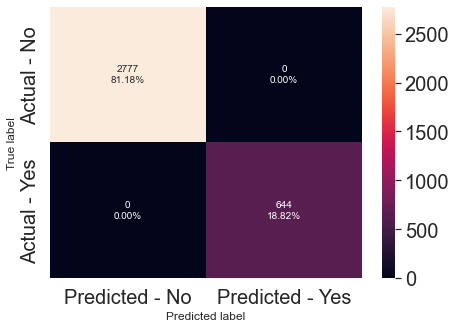

<IPython.core.display.Javascript object>

In [106]:
# Training data Confusion Matrix
make_confusion_matrix(dtree, X_train, y_train)

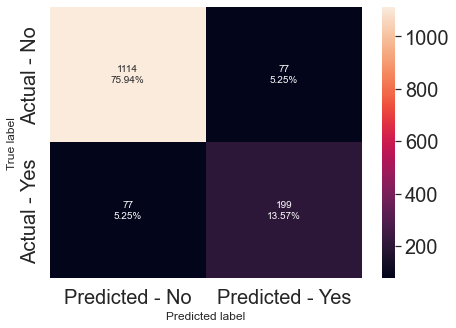

<IPython.core.display.Javascript object>

In [107]:
# Test data confusion matrix
make_confusion_matrix(dtree, X_test, y_test)

In [108]:
base_dtree_scores = get_metrics_score(model_name, dtree)
score_list.append(base_dtree_scores)

{
    "Model Name": "Base Decision Tree Model",
    "Train Accuracy": 1.0,
    "Test Accuracy": 0.8950238582140423,
    "Train Recall": 1.0,
    "Test Recall": 0.7210144927536232,
    "Train Precision": 1.0,
    "Test Precision": 0.7210144927536232,
    "Train F1": 1.0,
    "Test F1": 0.7210144927536232
}


<IPython.core.display.Javascript object>

In [109]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

<IPython.core.display.Javascript object>

#### Observations
* Base Decision Tree model is over fitting for train data. The test scores are lower than the train data.

### Bagging Classifier

In [110]:
model_name = "Base Bagging Classifier"
# base_estimator for bagging classifier is a decision tree by default
bagging_estimator = BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train, y_train)

BaggingClassifier(random_state=1)

<IPython.core.display.Javascript object>

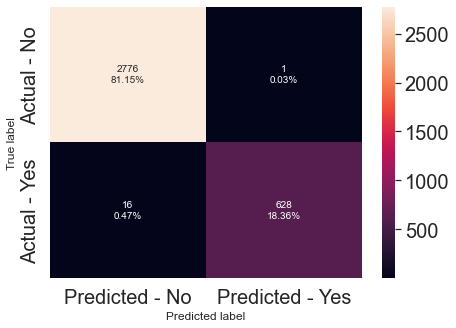

<IPython.core.display.Javascript object>

In [111]:
# Train data confusion Matrix
make_confusion_matrix(bagging_estimator, X_train, y_train)

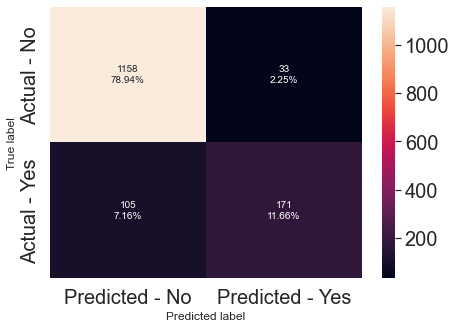

<IPython.core.display.Javascript object>

In [112]:
# Test data confusion Matrix
make_confusion_matrix(bagging_estimator, X_test, y_test)

In [113]:
base_bc_scores = get_metrics_score(model_name, bagging_estimator)
score_list.append(base_bc_scores)

{
    "Model Name": "Base Bagging Classifier",
    "Train Accuracy": 0.9950306927798889,
    "Test Accuracy": 0.9059304703476483,
    "Train Recall": 0.9751552795031055,
    "Test Recall": 0.6195652173913043,
    "Train Precision": 0.9984101748807631,
    "Test Precision": 0.8382352941176471,
    "Train F1": 0.9866457187745483,
    "Test F1": 0.7124999999999999
}


<IPython.core.display.Javascript object>

### Observations
* Base Bagging classifier model is overfitting the model for train data

### Base Random Forrest 

In [114]:
# Train the random forest classifier
model_name = "Base Random Forrest"
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

<IPython.core.display.Javascript object>

In [115]:
rf_estimator.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

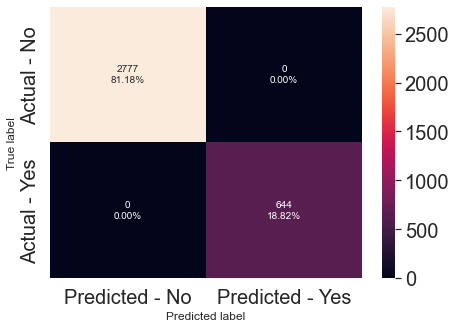

<IPython.core.display.Javascript object>

In [116]:
make_confusion_matrix(rf_estimator, X_train, y_train)

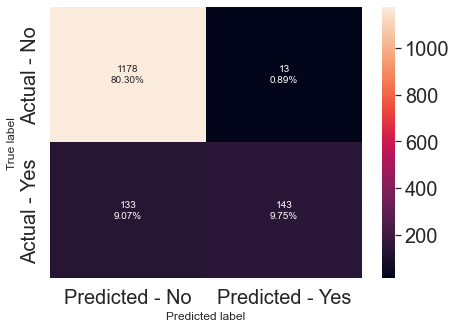

<IPython.core.display.Javascript object>

In [117]:
make_confusion_matrix(rf_estimator, X_test, y_test)

In [118]:
base_rf_scores = get_metrics_score(model_name, rf_estimator)
score_list.append(base_rf_scores)

{
    "Model Name": "Base Random Forrest",
    "Train Accuracy": 1.0,
    "Test Accuracy": 0.9004771642808452,
    "Train Recall": 1.0,
    "Test Recall": 0.5181159420289855,
    "Train Precision": 1.0,
    "Test Precision": 0.9166666666666666,
    "Train F1": 1.0,
    "Test F1": 0.662037037037037
}


<IPython.core.display.Javascript object>

### Observations:
* Base Random Forrest classifier is overfitting th model for the train data

### Base Models Performance Comparison

In [119]:
pd.DataFrame(score_list)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.00000,0.721014,1.000000,0.721014
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.99841,0.838235,0.986646,0.712500
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.00000,0.916667,1.000000,0.662037


<IPython.core.display.Javascript object>

### Observations on Base model performance
* Base Decision Tree Model has the best Recall and F1 score on test Data
* Base Bagging Classifier has the best Accuracy on test Data
* All the base models are overfitting for the train dataset

### Bagging Classifier with weighted decision tree

In [120]:
model_name = "Bagging Classifier weighted decision tree"
bagging_wt = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(
        criterion="gini", class_weight={0: 0.19, 1: 0.81}, random_state=1
    ),
    random_state=1,
)
bagging_wt.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.19,
                                                                      1: 0.81},
                                                        random_state=1),
                  random_state=1)

<IPython.core.display.Javascript object>

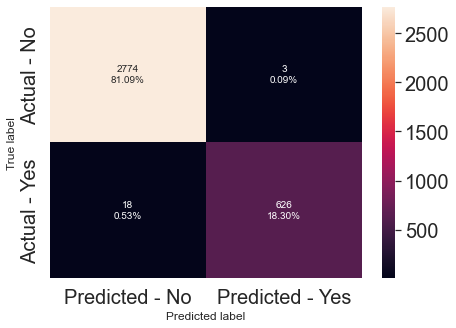

<IPython.core.display.Javascript object>

In [121]:
make_confusion_matrix(bagging_wt, X_train, y_train)

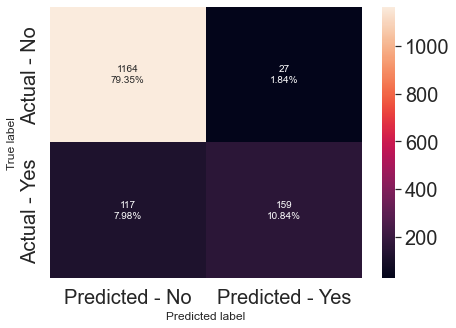

<IPython.core.display.Javascript object>

In [122]:
make_confusion_matrix(bagging_wt, X_test, y_test)

In [123]:
bagging_wt_scores = get_metrics_score(model_name, bagging_wt)
score_list.append(bagging_wt_scores)

{
    "Model Name": "Bagging Classifier weighted decision tree",
    "Train Accuracy": 0.9938614440222158,
    "Test Accuracy": 0.901840490797546,
    "Train Recall": 0.9720496894409938,
    "Test Recall": 0.5760869565217391,
    "Train Precision": 0.9952305246422893,
    "Test Precision": 0.8548387096774194,
    "Train F1": 0.9835035349567949,
    "Test F1": 0.6883116883116883
}


<IPython.core.display.Javascript object>

In [124]:
# Compare the scores with the base bagging classifier
pd.DataFrame([base_bc_scores, bagging_wt_scores])

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Base Bagging Classifier,0.995031,0.90593,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
1,Bagging Classifier weighted decision tree,0.993861,0.90184,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312


<IPython.core.display.Javascript object>

### Observations
* There was not much change in the test scores for Bagging Classifier weighted decision tree
* Precision score slightly increased with the Bagging Classifier weighted decision tree
* Recall score slightly increased with Bagging Classifier weighted decision tree

### Tuning Models

### Using GridSearch for Hyperparameter tuning model

### Tuning Decision Tree

In [125]:
model_name = "Tuned Decision Tree"

base_dtree = DecisionTreeClassifier(
    criterion="gini", class_weight={0: 0.19, 1: 0.81}, random_state=1
)
# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, None],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(base_dtree, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
tuned_dtree = grid_obj.best_estimator_

# Fit the best algorithm to the data.
tuned_dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.19, 1: 0.81}, max_depth=10,
                       min_impurity_decrease=0.0001, random_state=1,
                       splitter='random')

<IPython.core.display.Javascript object>

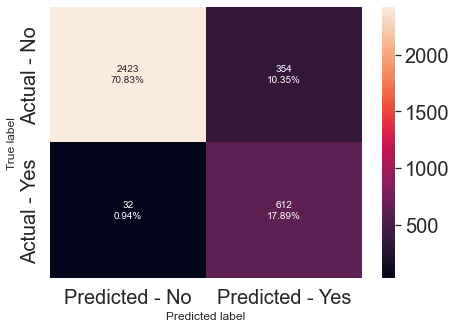

<IPython.core.display.Javascript object>

In [126]:
make_confusion_matrix(tuned_dtree, X_train, y_train)

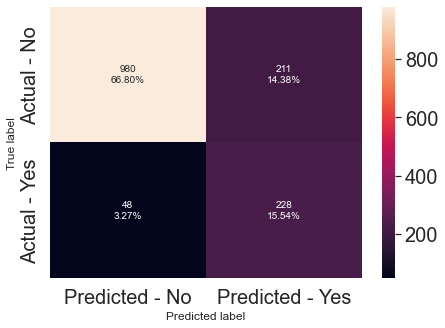

<IPython.core.display.Javascript object>

In [127]:
make_confusion_matrix(tuned_dtree, X_test, y_test)

In [128]:
tuned_dtree_score = get_metrics_score(model_name, tuned_dtree)
score_list.append(tuned_dtree_score)

{
    "Model Name": "Tuned Decision Tree",
    "Train Accuracy": 0.8871674948845367,
    "Test Accuracy": 0.8234492160872529,
    "Train Recall": 0.9503105590062112,
    "Test Recall": 0.8260869565217391,
    "Train Precision": 0.6335403726708074,
    "Test Precision": 0.5193621867881549,
    "Train F1": 0.760248447204969,
    "Test F1": 0.6377622377622377
}


<IPython.core.display.Javascript object>

In [129]:
pd.DataFrame([base_dtree_scores, tuned_dtree_score])

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.00000,0.721014,1.000000,0.721014
1,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.63354,0.519362,0.760248,0.637762


<IPython.core.display.Javascript object>

### Observations
* Tuned Decision Tree has better recall score than the base decision tree
* Tuned Decision Tree has poor Accuracy and poor precision compared with the base

### Tuning Bagging Classifier

In [130]:
model_name = "Tuned Bagging Classifier"

# grid search for bagging classifier
param_grid = {
    "base_estimator": [base_dtree],
    "n_estimators": [5, 7, 15, 51, 101],
    "max_features": [0.7, 0.8, 0.9, 1],
}

tuned_bg_cl = GridSearchCV(
    BaggingClassifier(random_state=1, bootstrap=True),
    param_grid=param_grid,
    scoring="recall",
    cv=5,
)
tuned_bg_cl.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(random_state=1),
             param_grid={'base_estimator': [DecisionTreeClassifier(class_weight={0: 0.19,
                                                                                 1: 0.81},
                                                                   random_state=1)],
                         'max_features': [0.7, 0.8, 0.9, 1],
                         'n_estimators': [5, 7, 15, 51, 101]},
             scoring='recall')

<IPython.core.display.Javascript object>

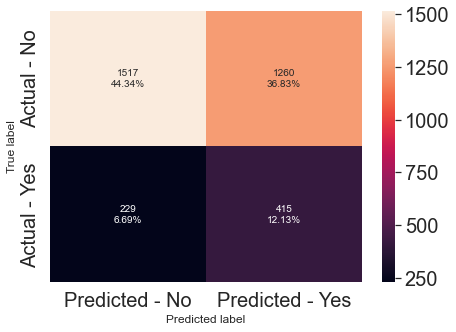

<IPython.core.display.Javascript object>

In [131]:
make_confusion_matrix(tuned_bg_cl, X_train, y_train)

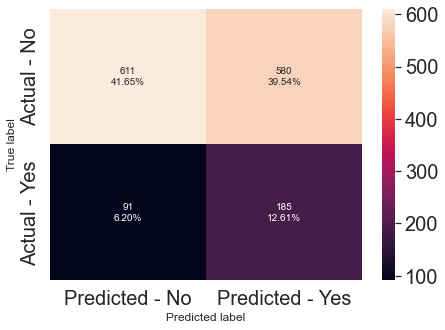

<IPython.core.display.Javascript object>

In [132]:
make_confusion_matrix(tuned_bg_cl, X_test, y_test)

In [133]:
tuned_bg_cl_scores = get_metrics_score(model_name, tuned_bg_cl)
score_list.append(tuned_bg_cl_scores)

{
    "Model Name": "Tuned Bagging Classifier",
    "Train Accuracy": 0.6444099378881988,
    "Test Accuracy": 0.6702898550724637,
    "Train Recall": 0.6444099378881988,
    "Test Recall": 0.6702898550724637,
    "Train Precision": 0.24776119402985075,
    "Test Precision": 0.24183006535947713,
    "Train F1": 0.3579128934885727,
    "Test F1": 0.3554274735830932
}


<IPython.core.display.Javascript object>

In [134]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037


<IPython.core.display.Javascript object>

### Observations
* Tunned Bagging Classifier shows better Recall score on Test data compared with the Base Bagging classifier
* But it is less than the Decision Tree Models

### Tuning Random Forest

In [155]:
model_name = "Tuned Random Forrest"
# Choose the type of classifier.
rf_estimator = RandomForestClassifier(random_state=1)

# base RF Estimator model has the following params
# {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': None,
#  'max_features': 'auto',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 100,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 1,
#  'verbose': 0,
#  'warm_start': False}

parameters = {
    "class_weight": [{0: 0.19, 1: 0.81}],
    "n_estimators": [50, 100, 125, 150],
    "max_features": np.arange(0.3, 0.7, 0.1),
    "min_samples_leaf": np.arange(1, 6),
    "max_samples": np.arange(0.4, 0.7, 0.1),
}

# Run the grid search
grid_obj = GridSearchCV(rf_estimator, parameters, scoring="recall", cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
tuned_rf_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
tuned_rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.19, 1: 0.81}, max_features=0.4,
                       max_samples=0.6, min_samples_leaf=5, random_state=1)

<IPython.core.display.Javascript object>

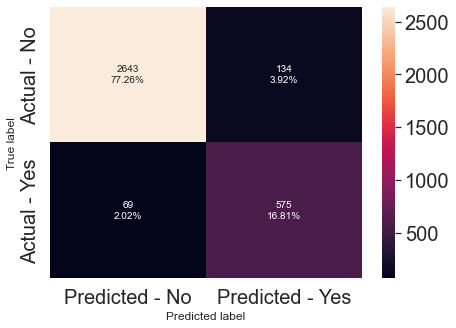

<IPython.core.display.Javascript object>

In [156]:
make_confusion_matrix(tuned_rf_estimator, X_train, y_train)

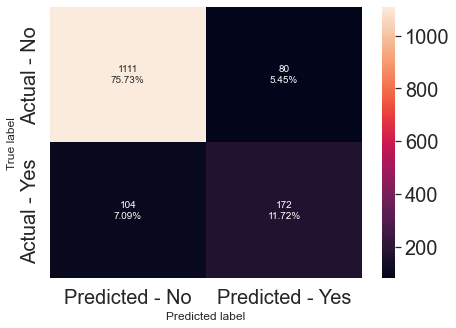

<IPython.core.display.Javascript object>

In [157]:
make_confusion_matrix(tuned_rf_estimator, X_test, y_test)

In [158]:
tuned_rf_scores = get_metrics_score(model_name, tuned_rf_estimator)
score_list.append(tuned_rf_scores)

{
    "Model Name": "Tuned Random Forrest",
    "Train Accuracy": 0.9406606255480854,
    "Test Accuracy": 0.874573960463531,
    "Train Recall": 0.8928571428571429,
    "Test Recall": 0.6231884057971014,
    "Train Precision": 0.8110014104372355,
    "Test Precision": 0.6825396825396826,
    "Train F1": 0.8499630450849963,
    "Test F1": 0.6515151515151516
}


<IPython.core.display.Javascript object>

In [159]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
8,Base XGBoost Classifier,0.999123,0.922972,0.995342,0.699275,1.000000,0.865471,0.997665,0.773547
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
9,Tuned Random Forrest,0.940661,0.874574,0.892857,0.623188,0.811001,0.682540,0.849963,0.651515
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037
7,Base Gradient Boost Classifier,0.886583,0.863667,0.453416,0.373188,0.890244,0.792308,0.600823,0.507389
6,Base AdaBoost Classifier,0.843321,0.847989,0.295031,0.315217,0.698529,0.719008,0.414847,0.438287


<IPython.core.display.Javascript object>

### Observations
* Tunned Random Forrest Model is performing better than the base Random Forrest in terms of Recall on test dataset
* But the F1 Score, precision and Accuracy have decreased
* As the final results depend on the parameters used/checked using GridSearchCV, There may be yet better parameters which may result in a better performance.

## Boosting Models

### AdaBoost Classifier

In [140]:
model_name = "Base AdaBoost Classifier"

abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

<IPython.core.display.Javascript object>

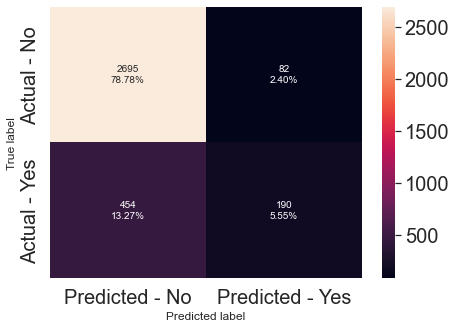

<IPython.core.display.Javascript object>

In [141]:
make_confusion_matrix(abc, X_train, y_train)

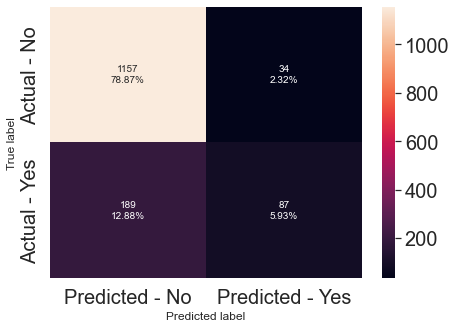

<IPython.core.display.Javascript object>

In [142]:
make_confusion_matrix(abc, X_test, y_test)

In [143]:
abc_score = get_metrics_score(model_name, abc)
score_list.append(abc_score)

{
    "Model Name": "Base AdaBoost Classifier",
    "Train Accuracy": 0.8433206664717918,
    "Test Accuracy": 0.8479890933878664,
    "Train Recall": 0.2950310559006211,
    "Test Recall": 0.31521739130434784,
    "Train Precision": 0.6985294117647058,
    "Test Precision": 0.71900826446281,
    "Train F1": 0.4148471615720524,
    "Test F1": 0.4382871536523929
}


<IPython.core.display.Javascript object>

In [144]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037
6,Base AdaBoost Classifier,0.843321,0.847989,0.295031,0.315217,0.698529,0.719008,0.414847,0.438287


<IPython.core.display.Javascript object>

### Observations
* Base AdaBoost Classifier model has the lowest recall score among all the models till now

### Gradient Boosting Classifier

In [145]:
model_name = "Base Gradient Boost Classifier"

gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

<IPython.core.display.Javascript object>

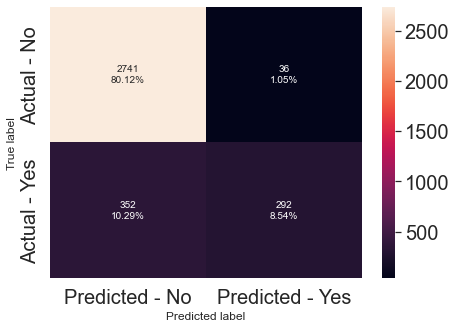

<IPython.core.display.Javascript object>

In [146]:
make_confusion_matrix(gbc, X_train, y_train)

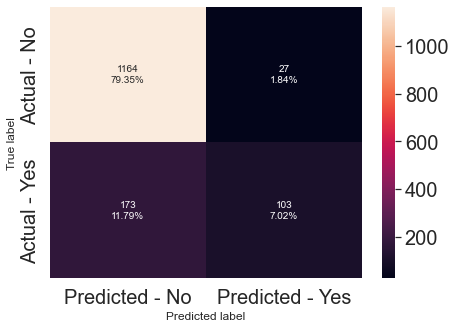

<IPython.core.display.Javascript object>

In [147]:
make_confusion_matrix(gbc, X_test, y_test)

In [148]:
gbc_scores = get_metrics_score(model_name, gbc)
score_list.append(gbc_scores)

{
    "Model Name": "Base Gradient Boost Classifier",
    "Train Accuracy": 0.8865828705057001,
    "Test Accuracy": 0.863667348329925,
    "Train Recall": 0.453416149068323,
    "Test Recall": 0.37318840579710144,
    "Train Precision": 0.8902439024390244,
    "Test Precision": 0.7923076923076923,
    "Train F1": 0.6008230452674898,
    "Test F1": 0.5073891625615763
}


<IPython.core.display.Javascript object>

In [149]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037
7,Base Gradient Boost Classifier,0.886583,0.863667,0.453416,0.373188,0.890244,0.792308,0.600823,0.507389
6,Base AdaBoost Classifier,0.843321,0.847989,0.295031,0.315217,0.698529,0.719008,0.414847,0.438287


<IPython.core.display.Javascript object>

### Observation
* Gradient Boosting Classifier model is better thann the AdaaBoost classifier model but still worse than the Bagging Classifier models in terms of the recall scores on the test data

### XGBoost Classifier

In [150]:
model_name = "Base XGBoost Classifier"
xgb = XGBClassifier(random_state=1, eval_metric="logloss")
xgb.fit(X_train, y_train)

/Users/sgirolkar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

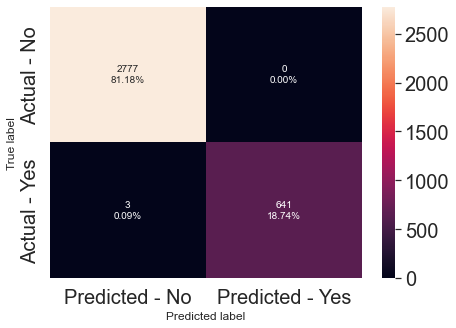

<IPython.core.display.Javascript object>

In [151]:
make_confusion_matrix(xgb, X_train, y_train)

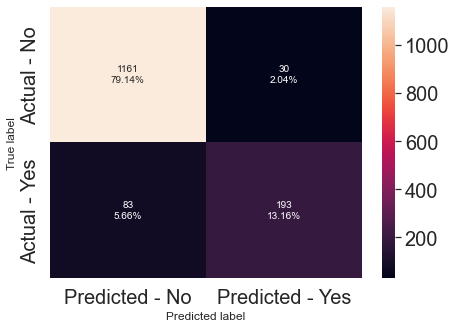

<IPython.core.display.Javascript object>

In [152]:
make_confusion_matrix(xgb, X_test, y_test)

In [153]:
xgb_scores = get_metrics_score(model_name, xgb)
score_list.append(xgb_scores)

{
    "Model Name": "Base XGBoost Classifier",
    "Train Accuracy": 0.9991230634317451,
    "Test Accuracy": 0.9229720518064076,
    "Train Recall": 0.9953416149068323,
    "Test Recall": 0.6992753623188406,
    "Train Precision": 1.0,
    "Test Precision": 0.8654708520179372,
    "Train F1": 0.9976653696498053,
    "Test F1": 0.7735470941883767
}


<IPython.core.display.Javascript object>

In [160]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
8,Base XGBoost Classifier,0.999123,0.922972,0.995342,0.699275,1.000000,0.865471,0.997665,0.773547
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
9,Tuned Random Forrest,0.940661,0.874574,0.892857,0.623188,0.811001,0.682540,0.849963,0.651515
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037
7,Base Gradient Boost Classifier,0.886583,0.863667,0.453416,0.373188,0.890244,0.792308,0.600823,0.507389
6,Base AdaBoost Classifier,0.843321,0.847989,0.295031,0.315217,0.698529,0.719008,0.414847,0.438287


<IPython.core.display.Javascript object>

### Observations
* The base xgboost clssifier is performing better than the AdaBoost, Gradient Booost and other Tunned Bagging classifiers. 
* But it is still not performing as good as the decision tree models
* This Model also has the best Precision, best Accuracy and best F1 score on the Test Dataset

### Tunning the Boosting Models

### Tuning AdaBooost model

In [162]:
model_name = "Tuned AdaBoost Classifier"

# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    # Let's try different max_depth for base_estimator
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": np.arange(0.1, 2, 0.1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1.4000000000000001, n_estimators=100,
                   random_state=1)

<IPython.core.display.Javascript object>

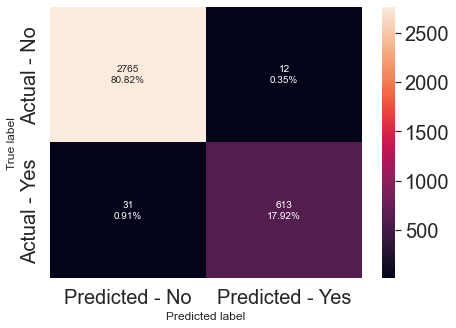

<IPython.core.display.Javascript object>

In [163]:
make_confusion_matrix(abc_tuned, X_train, y_train)

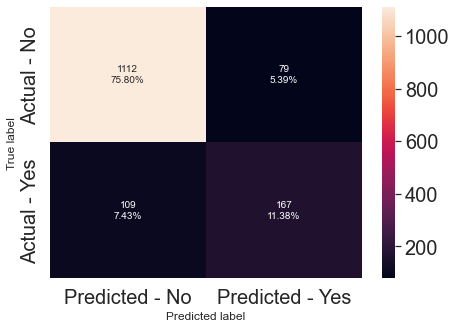

<IPython.core.display.Javascript object>

In [164]:
make_confusion_matrix(abc_tuned, X_test, y_test)

In [165]:
abc_tunned_scores = get_metrics_score(model_name, abc_tuned)
score_list.append(abc_tunned_scores)

{
    "Model Name": "Tuned AdaBoost Classifier",
    "Train Accuracy": 0.9874305758550131,
    "Test Accuracy": 0.8718473074301295,
    "Train Recall": 0.9518633540372671,
    "Test Recall": 0.605072463768116,
    "Train Precision": 0.9808,
    "Test Precision": 0.6788617886178862,
    "Train F1": 0.9661150512214342,
    "Test F1": 0.6398467432950191
}


<IPython.core.display.Javascript object>

In [166]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
8,Base XGBoost Classifier,0.999123,0.922972,0.995342,0.699275,1.000000,0.865471,0.997665,0.773547
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
9,Tuned Random Forrest,0.940661,0.874574,0.892857,0.623188,0.811001,0.682540,0.849963,0.651515
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
10,Tuned AdaBoost Classifier,0.987431,0.871847,0.951863,0.605072,0.980800,0.678862,0.966115,0.639847
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037
7,Base Gradient Boost Classifier,0.886583,0.863667,0.453416,0.373188,0.890244,0.792308,0.600823,0.507389


<IPython.core.display.Javascript object>

### Observaations
* Tunnned AdaBoost classifier model showed some improvement over the the base model but it still is not performing as good as the base XGBoost Model or the Tunned Bagging Models

### Tunning Gradient Boost Classifier

In [167]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

In [182]:
model_name = "Tunned Gradient Boost Classifier"

# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(
    init=AdaBoostClassifier(random_state=1), random_state=1
)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100, 150, 200, 250],
    "subsample": [0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9, 1],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.9, n_estimators=250, random_state=1,
                           subsample=0.9)

<IPython.core.display.Javascript object>

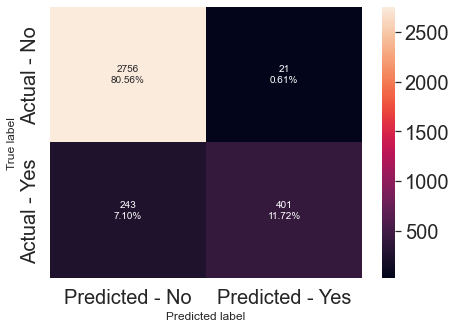

<IPython.core.display.Javascript object>

In [183]:
make_confusion_matrix(gbc_tuned, X_train, y_train)

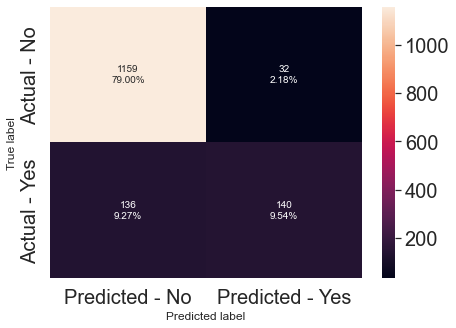

<IPython.core.display.Javascript object>

In [184]:
make_confusion_matrix(gbc_tuned, X_test, y_test)

In [185]:
gbc_tunned_scores = get_metrics_score(model_name, gbc_tuned)
score_list.append(gbc_tunned_scores)

{
    "Model Name": "Tunned Gradient Boost Classifier",
    "Train Accuracy": 0.9228295819935691,
    "Test Accuracy": 0.885480572597137,
    "Train Recall": 0.6226708074534162,
    "Test Recall": 0.5072463768115942,
    "Train Precision": 0.9502369668246445,
    "Test Precision": 0.813953488372093,
    "Train F1": 0.75234521575985,
    "Test F1": 0.625
}


<IPython.core.display.Javascript object>

In [186]:
pd.DataFrame(score_list).sort_values(by="Test Recall", ascending=False)

,Model Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
4,Tuned Decision Tree,0.887167,0.823449,0.950311,0.826087,0.633540,0.519362,0.760248,0.637762
0,Base Decision Tree Model,1.000000,0.895024,1.000000,0.721014,1.000000,0.721014,1.000000,0.721014
8,Base XGBoost Classifier,0.999123,0.922972,0.995342,0.699275,1.000000,0.865471,0.997665,0.773547
5,Tuned Bagging Classifier,0.644410,0.670290,0.644410,0.670290,0.247761,0.241830,0.357913,0.355427
9,Tuned Random Forrest,0.940661,0.874574,0.892857,0.623188,0.811001,0.682540,0.849963,0.651515
1,Base Bagging Classifier,0.995031,0.905930,0.975155,0.619565,0.998410,0.838235,0.986646,0.712500
10,Tuned AdaBoost Classifier,0.987431,0.871847,0.951863,0.605072,0.980800,0.678862,0.966115,0.639847
3,Bagging Classifier weighted decision tree,0.993861,0.901840,0.972050,0.576087,0.995231,0.854839,0.983504,0.688312
2,Base Random Forrest,1.000000,0.900477,1.000000,0.518116,1.000000,0.916667,1.000000,0.662037
11,Tunned Gradient Boost Classifier,0.922830,0.885481,0.622671,0.507246,0.950237,0.813953,0.752345,0.625000


<IPython.core.display.Javascript object>

### Observation
* Tunned Gradient Boost Classifier did only slightly better than the base model 


## Choosing the Model

Based on the Recall scores on the Test Data, __Tunned Decision Tree Model__ Prreforms the besst<br>
But oveall balanced performance is offered by the __Base XGBoost Model__. This model can also be further tuned to get better recall.<br>
Because in this problem, along with identifying the potential cusstomers, we are also trying tor reduce the cost of marketing, It is advisable to choose the __Base XGBoost Model__.

In [188]:
pd.DataFrame([xgb_scores]).T

,0
Model Name,Base XGBoost Classifier
Train Accuracy,0.999123
Test Accuracy,0.922972
Train Recall,0.995342
Test Recall,0.699275
Train Precision,1.0
Test Precision,0.865471
Train F1,0.997665
Test F1,0.773547


<IPython.core.display.Javascript object>

Let's take a look at the features used by this model.

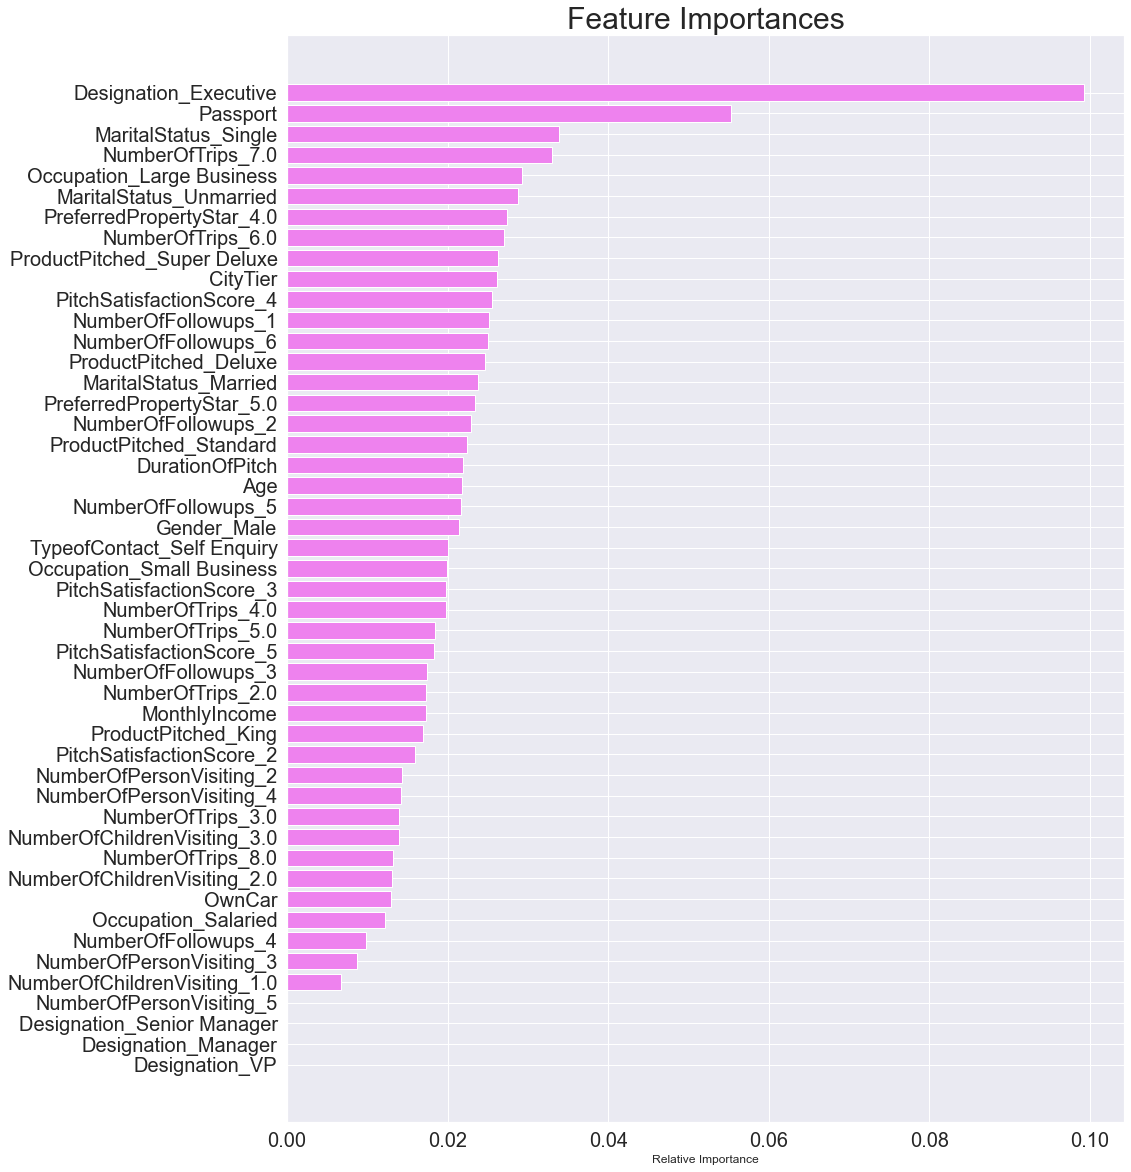

<IPython.core.display.Javascript object>

In [192]:
importances = xgb.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(15, 20))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Conclusions
* We analyzed the "Customer details" and "Customer Interaction Data" for "Visit with Us" using different techniques
* We created profiless for customers to pitch various packages
* We used Decision Tree Classifier, Bagging, Random Forrest and varius Boosting classifiers to build a predictive models for the same.
* The model built can be used to predict if a customer will purchase the package.
* We visualized  confusion matrix and compared the performance scores of different models.
* From the comparisons of the model performances we suggested __Base XGBoost Model__ to be best suited. We also recommend further tunning this model to improve recall

## More Insights

During the EDA process we also established the profiles for various packages currently offered by the company
### Customer Profile for Basic Package
* Designation Executive
* City Tier 1
* Self Enquiry
* Male
* Has Passport
* Owns a car
* Salaried
* Age less than 35
* Single
* Monthly Income 20K to 30K
* Number of persons visiting 3

### Customer profile for Deluxe Package
* Designation Manager
* Self Enquiry
* City Tier 3
* Male
* Age 35 to 42
* Married
* Occupation Small Business
* Does not have passport
* Owns a car

### Customer profile for King Package
* Designation VP
* Self Enquiry
* Age 45 to 50
* Monthly In come 34K to 39K
* Female
* Occupation Small Business
* City Tier 1
* Has Passport
* Owns a car
* prefers 4 star property

### Customer Profile for Standard package
* Designation: Senior Manager
* Self Enquiry
* Age 35 to 40 years
* Monthly Income 22K to 25K
* City Tier 3
* Married
* Male
* Prefers 3 star property
* Occupation: Small Business
* Has Passoprt
* Owns a car

### Customer Profile for Super Deluxe package
* Designation AVP
* Age 40 to 45 years
* Monthly Income 28K to 32K
* Owns a car
* Has Passport
* Company Invited
* Male
* Single
* Occupation: Salaried
* City Tier 3
* Prefers 3 star property